# 0. ML task: predict housing prices

We will work on an end-to-end ML project. We will learn to predict housing prices for districts in California in the 90s.

Assume that currently this task is done manually by real estate experts who study the markets, but the process takes a lot of time and is prone to errors. Can we do better? perhaps, using ML.

What data can we use? The census data looks like a good dataset to exploit for this purpose, since it includes the median housing prices of thousands of districts, as well as other data. This data includes metrics such as the population, median income, and median housing price for many districts in California. A district is the smallest geographical unit for which the US Census Bureau publishes sample data (typically has a population of 600 to 3,000 people). 

Our model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

## Frame the ML problem

- Is it supervised, unsupervised, semi-supervised or Reinforcement Learning? 
    - supervised; since we have labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price). 

- Is it a classification task, a regression task, or something else? 
    - multiple regression - univariate; predict a single value for each instance/ district. 
    
- Should you use batch learning or online learning techniques? 
    - There is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should do just fine.
    - If the data were huge, you could either split your batch learning work across multiple servers (using the MapReduce technique) or use an online learning technique.

# 1. Imports

In [1]:
# Typically in a script file, we write all import statements 
# at the top of the file.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
print(sys.version_info)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
print(sklearn.__version__)

sys.version_info(major=3, minor=9, micro=16, releaselevel='final', serial=0)
1.2.1


In [2]:
# Common imports

import numpy as np
import pandas as pd

Note about matplotlib

**Matplotlib** relies on a user-specified graphical backend to draw on your screen. So before you can plot anything, you need to specify which backend Matplotlib should use. The simplest option is to use Jupyter’s magic command `%matplotlib inline`. This tells Jupyter to set up Matplotlib so it uses Jupyter’s own backend. Plots are then rendered within the notebook itself. Note that calling `plt.show()` is optional in a Jupyter notebook, as Jupyter will automatically display plots when a cell is executed.

In [3]:
# To plot pretty figures

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# to use matplotlib pyplot's defaults
plt.rcdefaults()

# 2. Obtain the Data

In [4]:
# write a small function to read in the data

def load_housing_data(housing_path):
    csv_path = housing_path
    return pd.read_csv(csv_path)

In [5]:
# load the data

housing = load_housing_data("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 3. A first look at the data

## counts

Observe if any columns have missing values - we will need to take care of these. Notice the `dtype` of each field. dtype = **object** refers to objects/instances of a class. When reading in text data, object most commonly refers to a string (the String class).

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## counts of categorical attributes

In [7]:
# determine the values found in the ocean_proxmity column - a categorical attribute

housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## summary statistics

In [8]:
housing.shape

(20640, 10)

In [9]:
# .describe() uses all numeric columns, or you can select a subset of the columns

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## histograms

To create plots, Pandas gives us convenience functions, which allow us to call a plot_type plot directly on a DataFrame. The command is `DF.plot_type()` - with plot_type replaced with the type of plot that you want. Under the hood, this is calling the Maplotlib- Pyplot  functions for us. It uses matplotlib as the backend by default, but we can also change it to to use another plotting package if we like using the parameter `backend`

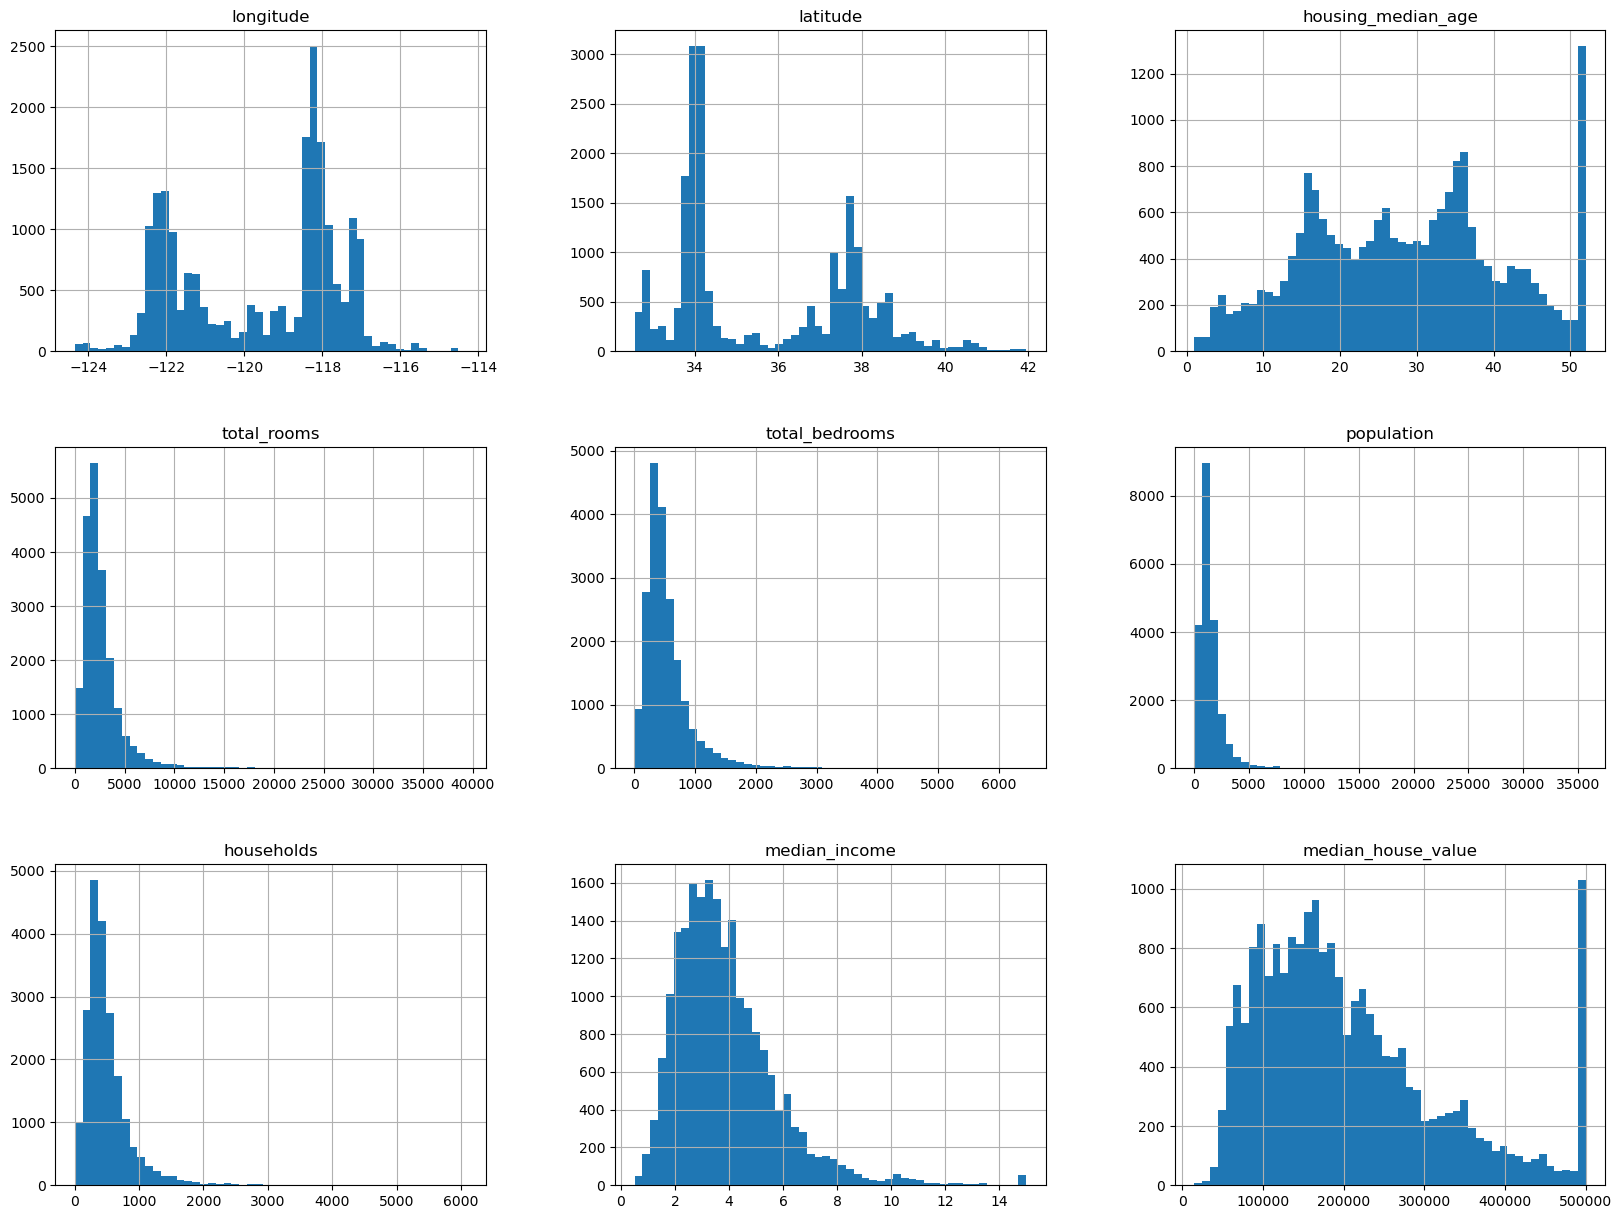

In [10]:
# DF.hist() plots the nine numerical features, excludes the categorical feature ocean_proximity

housing.hist(bins=50, figsize=(20,15))

# this is optional inside a Jupyter notebook
plt.show()

OR alternatively, we can also call `DF.plot()` and specify what kind of plot we want using parameter `kind`.


In [11]:
# observe that this method has so many parameters

#housing.plot?

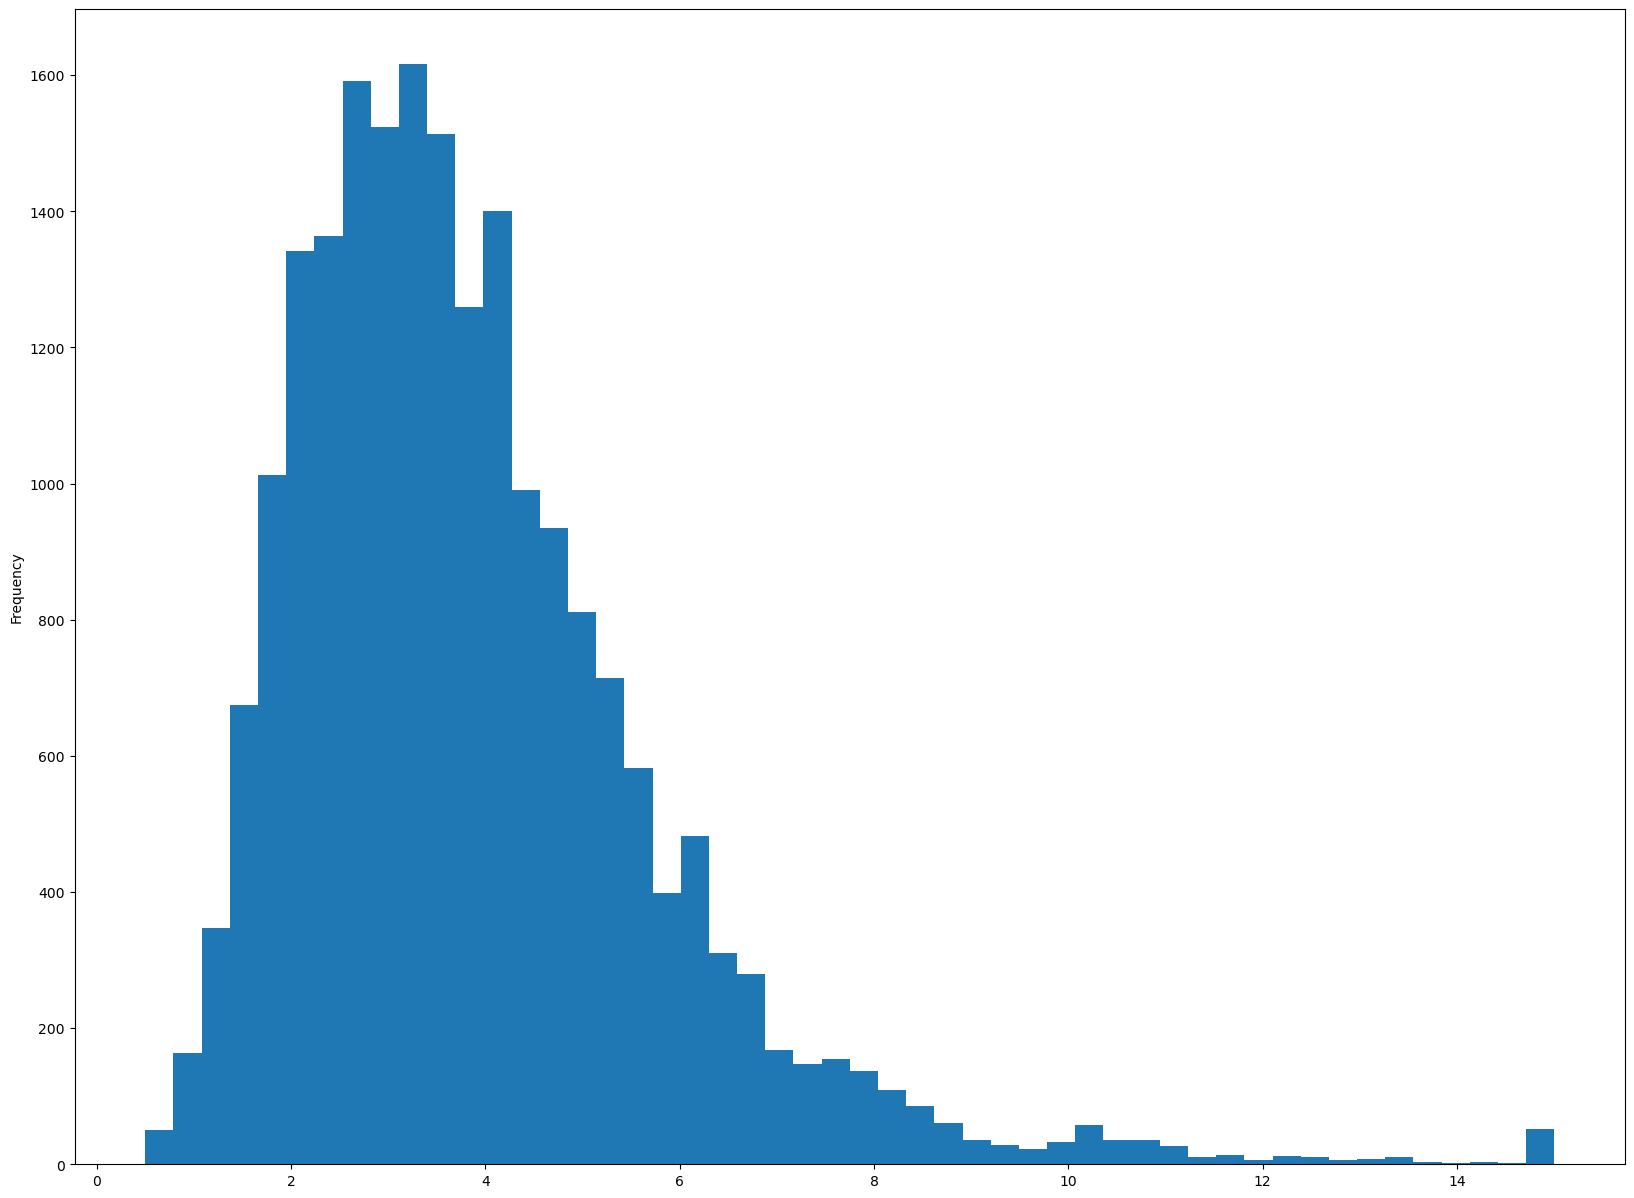

In [12]:
# let's select one column and specify some additional parameters

housing['median_income'].plot(kind='hist',
              bins=50, 
              figsize=(20,15))

plt.show()

## What do we learn from the plots?

1. Attributes have very ***different scales***


2. *median income* attribute only goes up to 15. In this data, the numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000).
    - The little spike at the end (at 15) indicates that the data might also be ***truncated (capped)*** so that any observation with medan icnome above 15K was measured as 15K. 


3. The *housing median age* and the *median house value* appear like they were also ***capped***. The latter may be a serious problem since it is your target attribute (your dependent variable). 
    - The ML algorithm may learn that prices never go beyond that limit, and consequently cannot make good predictions for homes with value > 500K. If, when deployed, the model will be faced with observations whose prices are greater than 500K, this is a problem. If not, it is okay to proceed.
    - If your model needs to be able to predict values > 500K, then you can either:
        - Collect better data: get correct labels for the districts whose labels were capped (remove the truncation).
        - Remove the observations with capped values in the target from the training set (and also from the test set). This allows the model to learn without truncation.


4. Many histograms are tail-heavy, i.e. ***skewed***. Left skew means a long tail exists on the right of the median.
    - usually is a problem if it occurs in the DV or target.


# 4. Create a test set

Before exploring any further, we will want to separate out a test set to avoid **data snooping bias** or **data leakage**. We will want to keep aside some unseen data, to serve as our test set for the models that we wish to evaluate.

Pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside.

## **SKIP THIS SECTION - read if interested**

## A custom function to split the data

In this custom function, we will first randomly shuffle indices using `np.random.permutation()` which will permute an array of ints of the length of the dataset.

We then compute `test_ratio% * len(data)` to be the test set size. We obtain that number of indices from the array of random indices and then use `DF.iloc[]` to obtain the test data as a DF. Do the same steps for training data.

In [13]:
# first, we set a random see - it can be any int

np.random.seed(42)                                             # set seed for repeatability

In [14]:
# define a new function that will perform this permutation of index and do a 80-20 random split

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]            #obtain the test indices from 0 to test_set_size
    train_indices = shuffled_indices[test_set_size:]           #obtain the train indices (the rest)
    return data.iloc[train_indices], data.iloc[test_indices]   # select test and train from the data DF

In [15]:
# call the above function with test set ratio 0.2 (20%)
train, test = split_train_test(housing, 0.2)

In [16]:
print(len(train))
print(len(test))

16512
4128


## OPTIONAL: stable permutations

Above, we created a random shuffled set of test/ train data. But when new data arrives, the above algorithm will break - as in, the same observation that was earlier in the test set could now be in next train set, causing data leakage across model updates.

One solution:\
Assign an immutable identifier to each observation, and ensure that once selected to be in the test that, that observation will always remain in the test set in future rounds of model training as well. To achieve this, new data should only be appened to the end of the dataset, with new ids.

For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

To compute a quick hash, we can use the `crc32` class (Cyclic Redundancy Check) from `zlib` module , which computes a 2-bit checksum of any piece of data, and returns an unsigned int.


In [17]:
from zlib import crc32

# The prefix 0x means the next number is written in the hexadecimal (base 16) numbering system
# 0xFFFFFFFF is hexadecimal for (2**32) -1
# in 32-bit mode, the hexadecimal value 0xFFFFFFFF is equivalent to the decimal value of "-1". 
# In 64-bit mode, however, the decimal equivalent is 4294967295.


def test_set_check(identifier, test_ratio): 
    # cast the id to int64, and convert to hex and compare with test_ratio * max hash-value (which is 2^32)
    # if the hash(id) is less than than the latter, return True (i.e. it is in Test set)
    # else return False (in Train set)
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32


def split_train_test_by_id(data, test_ratio, id_column):
    
    # obtain a Series of ids
    ids = data[id_column]

    # we use .apply() to apply a custom function to all values in the Series or DF
    # recall that apply() is typically combined with a lambda function 
    # that specifies the calculation to perform for each value in the Series or DF
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    
    # in_test_set is a Series and we use .loc[] with a boolean array to select which values 
    # are in train and test sets
    # return a tuple of DF (train set, test set)
    return data.loc[~in_test_set], data.loc[in_test_set]


In [18]:
housing_with_id = housing.reset_index()   # adds a new `index` column with index 0, 1, 2....len(data)-1
train, test = split_train_test_by_id(housing_with_id, 0.2, "index")

In [19]:
print(len(train))
print(len(test))

16512
4128


**NOTE: when to use ! or ~** \
`!` is a comparison operator used to compare whether two values are ***not equal*** \
`~` is the ***negation*** operator (produces the opposite boolean)

## **END OF SKIP**

## Using sklearn built-in functions for sample splitting

### Random sampling

We can use the `train_test_split()` function found in `sklearn.model_selection` which splits arrays or matrices into random train and test subsets. We can specify the size of the test split or train split as a parameter. For reproducibility, always set the `random_state` parameter to any int.

sklearn has many specialized sub-modules. You will see that we will often have to call functions that are inside other sub-modules. For example sklearn.model_selection sub-module contains many functions that pertain to model selection.

In [20]:
# when using random functions, we will often set a random seed for reproducibility
# 42 because, it is the "Answer to the Ultimate Question of Life, the Universe, and Everything", 
# calculated by a supercomputer named Deep Thought over a period of 7.5M years.
# (The Hitchhiker's Guide to the Galaxy by Douglas Adams)

np.random.seed(42)                                             # set seed for repeatability

In [21]:
# a common way in which we will import specific functions from sklearn's sub-modules

from sklearn.model_selection import train_test_split

In [22]:
type(housing)

pandas.core.frame.DataFrame

In [23]:
# The first argument is data as an ndarray or Pandas DF - the data that we want to split into train and test.
# the second argument is the size of the testing data (training data will be 1-0.2)
# the third argument is the random state (a seed, which is initialzied by any int, we do this for reproducibility)
           # many sklearn methods and estimators that use randomization will have this parameter
# this method will produce 2 arrays as output - in order

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


But we actually also need to separate the target from the X's
So let us define the X and y (the case is just standard practice - y is in lower case and X is upper)

In [24]:
# define the target

y_housing = housing['median_house_value']

# create the X columns by selecting from column names where the namme is not equal to the target

X_cols = housing.columns[housing.columns != 'median_house_value']
X_housing = housing[X_cols] 

In [25]:
# if the positional arguments are multiple arrays, then each of them will be split two-ways.
# notice here, we are giving it a tuple of two arrays - X_housing and y_housing
# this method will produce 4 arrays as output - in order

X_train, X_test, y_train, y_test = train_test_split(X_housing, y_housing, test_size=0.2, random_state=42)

In [26]:
# verify column sizes

print(len(train_set.columns))   # this combined X and y
print(len(X_train.columns))     # this contains only X with one column y removed 

10
9


### Stratified sampling

With random sampling, there is no guarantee that the splits have the same distributions of attributes. Ideally we want our splits to be representative of the population (from which we created the splits). This is usually not problematic for large data.

Suppose we talked with experts who told us that the median income is a very important attribute to predict median housing prices. We may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, it is easier to first create an income category attribute using `pd.cut()`

It is easier to ensure that the values in a categorical attribute appear in both test and train sets (since there is a limited number to match). It is harder to do so for continuous values.

In [27]:
# let us find out how median income is distributed in the dataset - it goes from 0 to 15

housing["median_income"].describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

In [28]:
# pd.cut() will give us bins of equal length/sizes
# but may contain very different number of observations in each bin
# output is skewed

housing["income_cat"] = pd.cut(housing["median_income"], 
                               5,
                               labels=[1, 2, 3, 4, 5])

In [29]:
# let's look at the distribution of observations for income_cat
# set parameter normalize = True to get the relative frequencies of the unique values.

print(housing["income_cat"].value_counts(normalize = True).sort_index())


1    0.469138
2    0.440310
3    0.072093
4    0.013130
5    0.005329
Name: income_cat, dtype: float64


In [30]:
# we can also specify the bins we want instead of the asking for a fixed number of bins
# this will overwrite the existing column
# output looks a bit more normal

housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

print(housing["income_cat"].value_counts(normalize = True).sort_index())

1    0.039826
2    0.318847
3    0.350581
4    0.176308
5    0.114438
Name: income_cat, dtype: float64


In [31]:
# pd.qcut() will give us bins with equal number of observations in each

housing["income_qcat"] = pd.qcut(housing["median_income"], 
                                 q=5,
                                 labels=[1, 2, 3, 4, 5])

housing["income_qcat"].value_counts(normalize = True).sort_index()

1    0.200097
2    0.200145
3    0.199758
4    0.200000
5    0.200000
Name: income_qcat, dtype: float64

<Axes: >

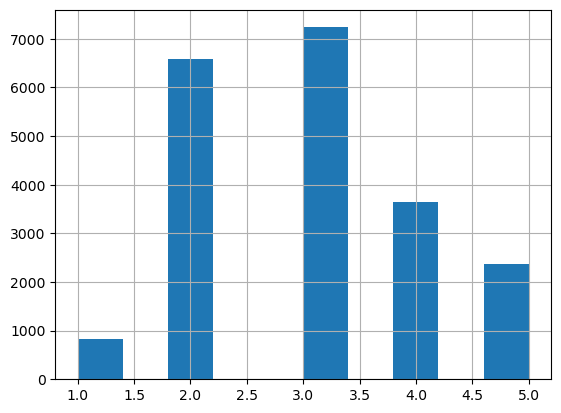

In [32]:
housing["income_cat"].hist()

Next, we can use `StratifiedShuffleSplit()` function from `sklearn.model_selection`. This function provides the indices that can be used to create the train and test sets of data.

This is a combination of `StratifiedKFold()` and `ShuffleSplit()` functions, and returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class. The parameter `n_splits` is the number of re-shuffling & splitting iterations (default=10).

For this function, we will use the original data that contains both X and y - otherwise if we stratiofy X and Y spearately, they may not match- that X and y not guaranteed to go together.


In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# split is a StratifiedShufleSplit object. 
# Its .split() method generates two sets of indices to split data into training and test sets.
# split is based on the second parameter only - here, the column income_cat
# which serves as the target for StratifiedShuffleSplit
# the first parameter hosuing is just a dummy - it is not used, but we have to give it something

for train_index, test_index in split.split(housing, housing["income_cat"]):
    print("!")
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


!
!
!
!
!


In [34]:
# the distribution of median income categories in the test set matches that in the original data very closely

strat_test_set["income_cat"].value_counts(normalize = True).sort_index()

1    0.039971
2    0.318798
3    0.350533
4    0.176357
5    0.114341
Name: income_cat, dtype: float64

In [35]:
# the distribution of median income categories in the train set matches that in the original data very closely

strat_train_set["income_cat"].value_counts(normalize = True).sort_index()

1    0.039789
2    0.318859
3    0.350594
4    0.176296
5    0.114462
Name: income_cat, dtype: float64

Now we can get rid of the extra column - income_cat and income_qcat

In [36]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop(["income_cat", "income_qcat"], axis=1, inplace=True)

Let us create a deep copy and rename them as `train` and `test` sets. 

In [37]:
train = strat_train_set.copy()
test = strat_test_set.copy()

# 5. Data exploration

## scatter plots

`DF.plot()` - specify parameter `kind="scatter"` and we can specify x and y by just calling the name of the columns as strings. If we set a `label` parameter, then we can use that in the legend.



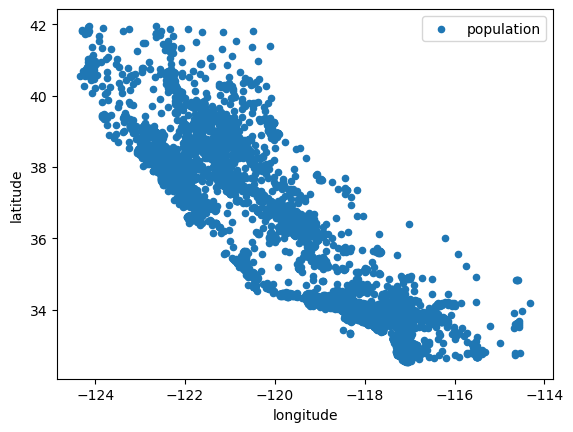

In [38]:
# if you want to show your plt using qt - will open a popup window (instead of inline)
# uncomment the below line
#%matplotlib qt

train.plot(kind="scatter", 
           x="longitude", 
           y="latitude", 
           label="population")

plt.legend(loc="best")     # uses the value of parameter label in a legend

plt.show()

Notice that it resemebles the California state map.

You can provide the colors you want to use with the parameter `color`,  and specify RGB values in [0.0, 1.0] as a 3-tuple or 3-element list, or specify color as a string.

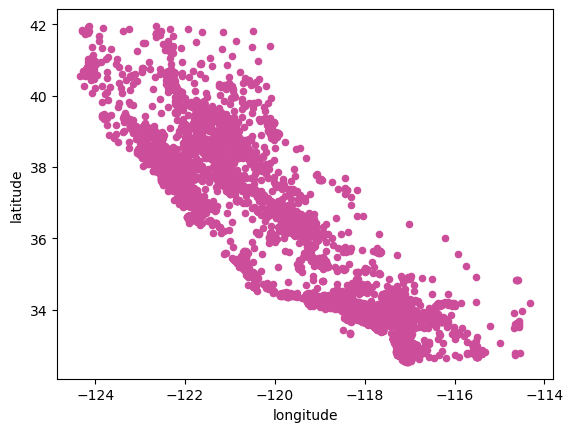

In [39]:
# if you changed the backend above - change it back to inline
#%matplotlib inline

train.plot(kind="scatter", 
           x="longitude", 
           y="latitude", 
           color=(0.8, 0.3, .6)
)
plt.show()

Some additional parameters: 
- `alpha` sets the transparency of the markers, in the range [0.0, 1.0]
- `figsize` can set the size of the image
- `cmap` can be used to set the coloring theme

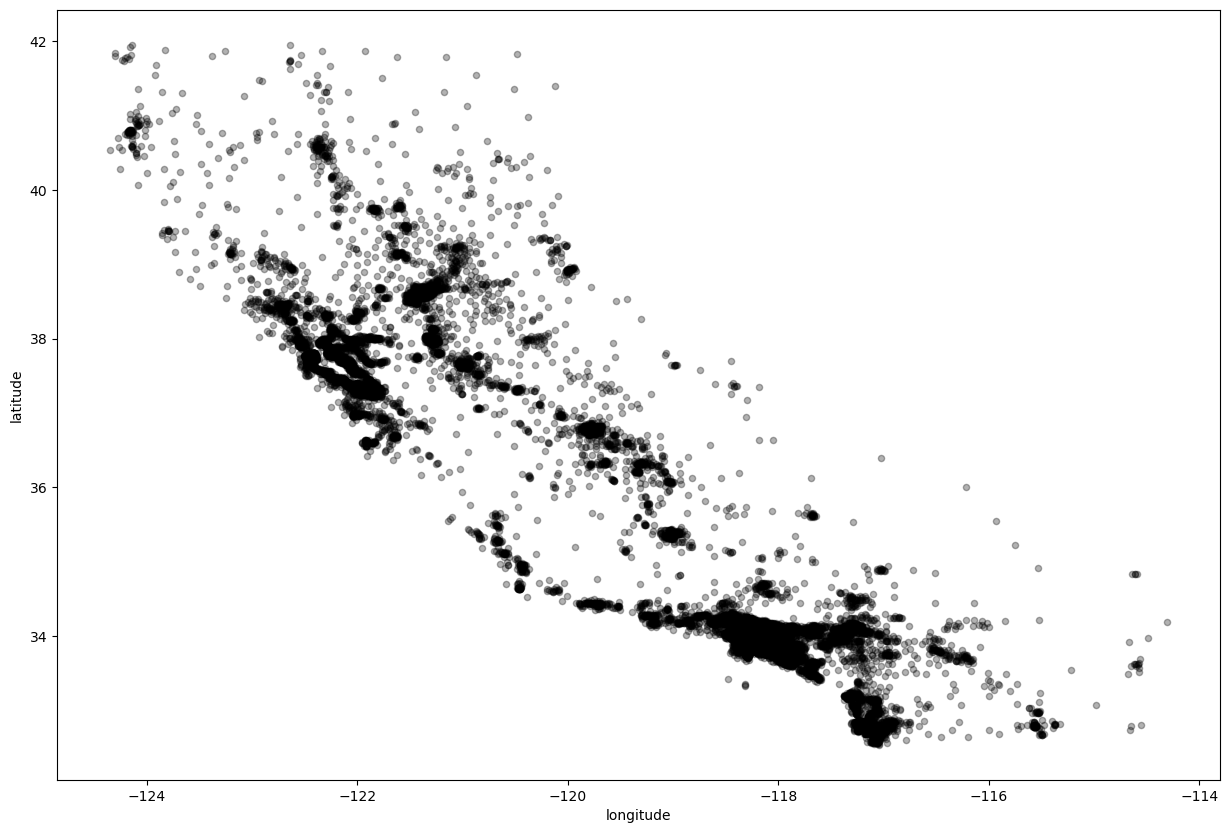

In [40]:
train.plot(kind="scatter", 
           x="longitude", 
           y="latitude", 
           color='black', 
           alpha = 0.3,
           figsize =(15,10), 
)
plt.show()

In the above plot, we can se the high density areas, where multiple observations (districts) overlap. But all the markers are of the same size. We can also change the size of the marker based on some column of values in the data.

In the next plot, let us try to set color of the marker to random values (it will use a default colormap), and set the size of each marker to the population value / 100.

If we want to provide a sequence of values with different colors for each observation, we can use the `c` parameter and not the `color` parameter. Then give it a seauence (Series) of values.

Similarly, we can provide a sequence (Series) of size values - one for each observation - using the `s` parameter.

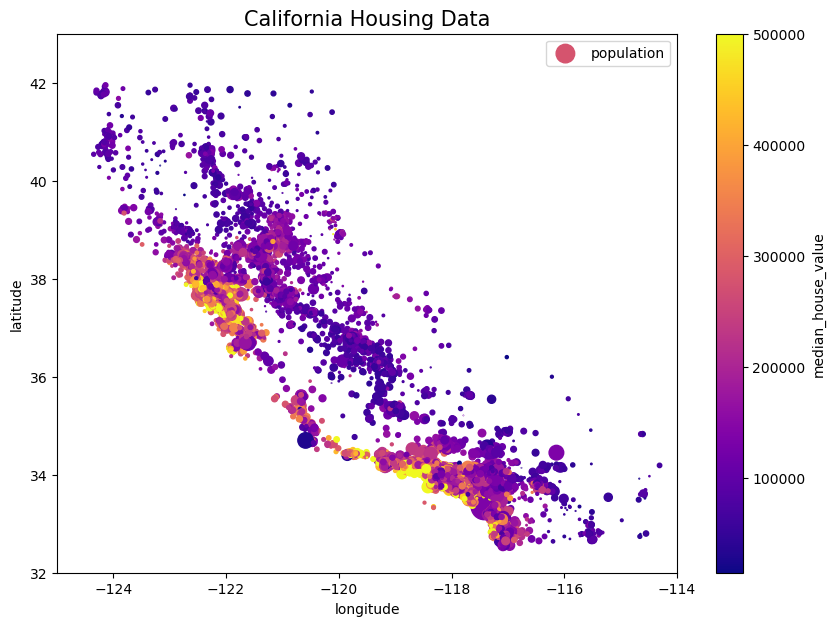

In [41]:
np.random.seed(42)
#colors = np.random.rand(len(train))
train.plot(kind="scatter",
             x="longitude", 
             y="latitude", 
             s=train["population"]/100, 
             c="median_house_value", 
             label="population",
             cmap='plasma',
             figsize=(10,7), 
             colorbar = True
)

plt.legend()
plt.title("California Housing Data", size = 15)

# you can optionally specify the x-axis and y-axis
plt.axis([-125, -114, 32, 43])

plt.show()

From the above map, we can get a sense that housing prices are higher near the ocean - western edges. There are a few clusters with large circles (large population density). Prices appear to be (negatively) related to population density - since the yellow (high prices) tend to be on circles of small-medium size (pop density).

## scatter matrix

We can obtain scatterplots of multiple pairs of columns using a `scatter_matrix()` function from `pandas.plotting` module. This is a different plotting module - scatter matrix will create NxN scatter plots with histograms on the diagonal.

In [42]:
train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

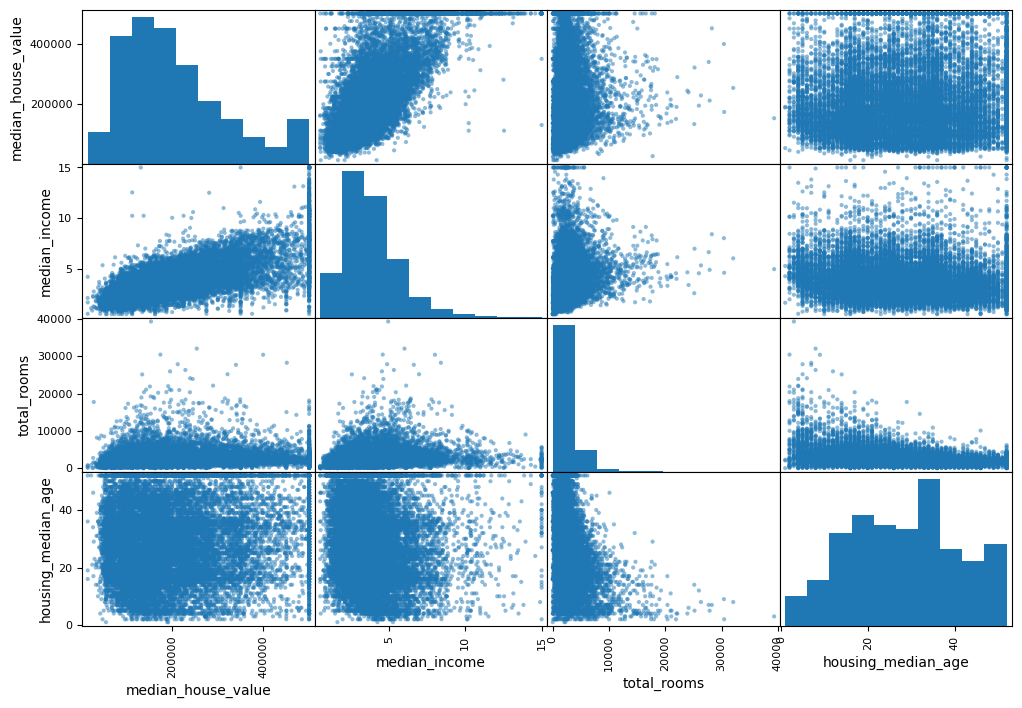

In [43]:
from pandas.plotting import scatter_matrix

# let us select a subset of the numeric attributes

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(train[attributes], figsize=(12, 8))
plt.show()

## pair plots

The Seaborn module provides us a plotting functions with a slightly different look-and-feel. We will use the `sns.pairplot()` to see a different type of scatter matrix.
On the diagonal, we can ask for histogram or kernel denisty estimates.
We can specify optional parameter `hue` to color the points differently based on another column - ocean proximity.

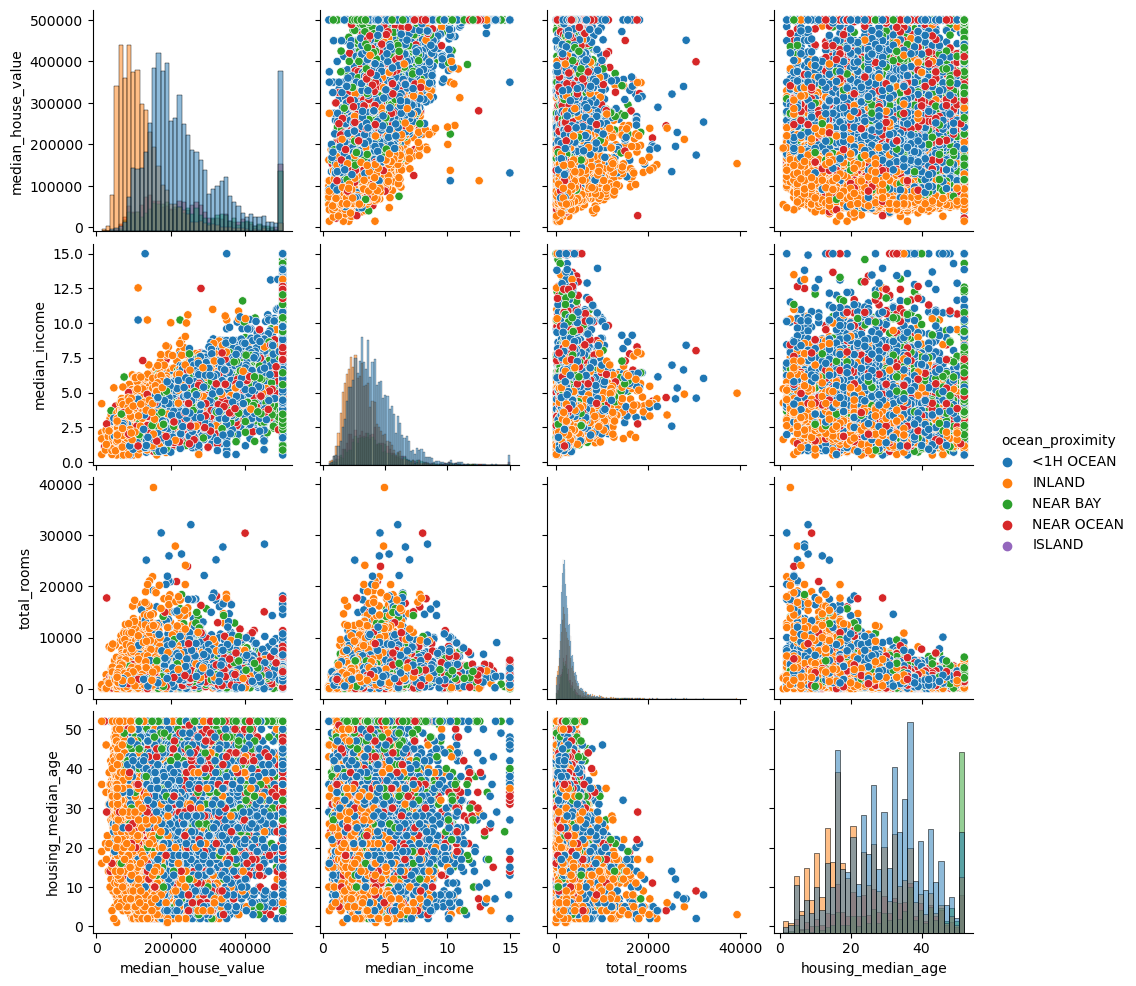

In [44]:
import seaborn as sns
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age", "ocean_proximity"]
sns.pairplot(train[attributes], 
             hue="ocean_proximity", 
             kind= "scatter", 
             diag_kind = "hist")

On both these plots, you can see the capping that takes place in the median_house_value, see the horizontal line of markers when median_house_value = 500000. 
Same thing happens in housing_median_age as well (capped at 50).

## correlations

Typically we are interested in learning about which features are correlated with the target. So we can obtain the correlation matrix and then examine the correlations with the target, by selecting just the target column (a Series of correlations).

`DF.corr()` computes **Pearson's correlation** between pairs of columns. The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). 

CAUTION: It may completely miss out on nonlinear relationships.

In [45]:
corr_matrix = train.corr()

C:\Users\u0625859\AppData\Local\Temp\ipykernel_30772\1550658072.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


In [46]:
# select the column named 'median_house_values' (Y or target) to see its correlations with other columns
# Let's show it in reverse sorted order
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687323
total_rooms           0.128795
housing_median_age    0.100961
households            0.060945
total_bedrooms        0.045510
population           -0.030417
longitude            -0.048705
latitude             -0.141223
Name: median_house_value, dtype: float64

# 6. Data cleaning / pre-processing

We identified a few data quirks that we may want to clean up before feeding the data to a Machine Learning algorithm, and we found interesting correlations between attributes, in particular with the target attribute. 

## taking logs
We noticed that some attributes have a tail-heavy distribution, so we may want to transform them (e.g., by computing their logarithm). After transforming, let's plot the histograms of the log vars to see that they look less skewed and  more normal than the raw variables.

In [47]:
# create new attributes using log transform - we will use np.log()

logtotrooms = np.log(train["total_rooms"])
loghholds = np.log(train["households"])
logpop = np.log(train["population"])

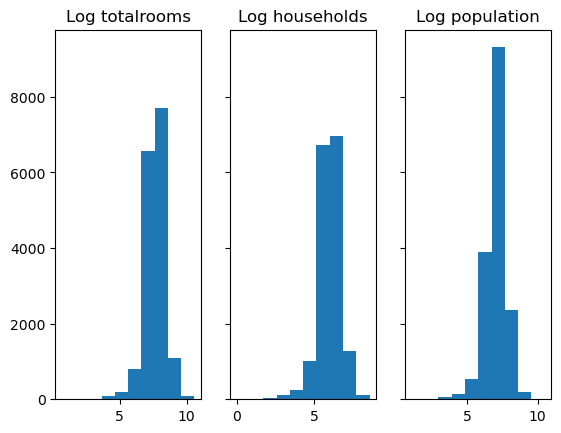

In [48]:
# let's plot the histograms to see what log transform does 
# let us create a figure with 3 subplots
# the plt.subplots() command allows us to specify number of rows and columns we want in the subplot.
# we can also specify whether we want them to share x-axis and y-axis.

fig, ax = plt.subplots(nrows=1, ncols=3 , sharey = True, sharex = False, )

# recall that the figure is the whole plot
# and within each figure there can be multiple drawing areas called axes.
# then for each axes, we specify what to plot and we set individual plot titles

ax[0].hist(logtotrooms)
ax[0].set_title("Log totalrooms")

ax[1].hist(loghholds)
ax[1].set_title("Log households")

ax[2].hist(logpop)
ax[2].set_title("Log population")

#fig.tight_layout()

plt.show()

## create new combinations of attributes
We may also want to create new attributes that are meaningful combinations of existing columns. For example, we will create the following 3 variables:

- the number of rooms per household
- the total number of bedrooms by the number of rooms
- the population per household 

Let's make a deep copy of the training data set. We will add new variables to the train_copy DataFrame for now. Later we will learn a better approach to adding new attributes using Custom Transformers.

In [49]:
train_copy = train.copy()

train_copy["rooms_per_household"] = train["total_rooms"]/train["households"]
train_copy["bedrooms_per_room"] = train["total_bedrooms"]/train["total_rooms"]
train_copy["population_per_household"]=train["population"]/train["households"]

Next, let us check to see whether our new features are meaningfully correlated with the target, median_house_values. You can see that many of them are. That's good.

In [50]:
# after creating train.corr(), you will have a DF of correlations.
# select just the target column ['median_house_value'] and 
# sort its correlation values in descending order (highest at the top)

train_copy.corr()['median_house_value'].sort_values(ascending = False)


C:\Users\u0625859\AppData\Local\Temp\ipykernel_30772\1333470809.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_copy.corr()['median_house_value'].sort_values(ascending = False)


median_house_value          1.000000
median_income               0.687323
rooms_per_household         0.144264
total_rooms                 0.128795
housing_median_age          0.100961
households                  0.060945
total_bedrooms              0.045510
population_per_household   -0.019786
population                 -0.030417
longitude                  -0.048705
latitude                   -0.141223
bedrooms_per_room          -0.254286
Name: median_house_value, dtype: float64

# 7. Preparation to apply ML algorithms

## 7.1 Scikit-learn
Scikit-learn is the package that we will use for ML. It contains the following types of **classes**

**ESTIMATORS**\
Any object that can estimate some parameters based on a dataset is called an estimator (e.g., an `imputer` is an estimator). The estimation itself is performed by the `fit()` method, and it takes only a dataset (X) as a parameter (or two datasets for supervised learning algorithms; the second dataset y contains the labels). Any other parameter needed to guide the estimation process is considered a ***hyperparameter*** (such as an imputer’s strategy), and it must be set as an instance variable (generally via a parameter of the constructor).

**TRANSFORMERS**\
Some estimators are also transformers. Some estimators (such as an `imputer`) can also transform a dataset; these are called transformers. The transformation is performed by the `transform()` method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters, as is the case for an imputer. All transformers also have a convenience method called `fit_transform()` that is equivalent to calling `fit()` and then `transform()` (but sometimes fit_transform() is optimized and runs much faster).

**PREDICTORS**\
Finally, some estimators, given a dataset, are capable of making predictions; they are called predictors. For example, the LinearRegression or LogisticRegression models are (estimators as well as) predictors. A predictor has a `predict()` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a `score()` method that measures the quality of the predictions, given a test set (and the corresponding labels, in the case of supervised learning algorithms).

Scikit-Learn provides reasonable default values for most parameters of the above objects, making it easy to quickly create a baseline working system.

## 7.2 Separate X and y
One of the first things to so is to separate the features from the target in the train and test data sets.

In [51]:
# drop from axis=1 (columns),drop produces a new array

train_X = train.drop("median_house_value", axis=1) 
train_y = train["median_house_value"].copy()

test_X = test.drop("median_house_value", axis=1)
test_y = test["median_house_value"].copy()

## 7.3 Handling missing values

Most ML algorithms cannot work with missing values in features, so we need to handle them.

In [52]:
# total_bedrooms and bedrooms_per_room have missing values, as seen below.
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 9763 to 2991
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16349 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


There are a few different ways to deal with missing values.
1. get rid of those observations with missing values (here each obs is a district)
2. get rid of the whole attribute or feature
3. set/replace the missing values to some new value (0, mean, medium, nearest-neighbor imputation etc.)

In [53]:
# option 1 - drop rows with missing vals in subset of columns

train_X.dropna(subset=["total_bedrooms"], axis=0)    
                            
# option 2 - drop specified columns

train_X.drop("total_bedrooms", axis=1)               
                             
# option 3 - replace with median using DF.fillna()

median = train_X["total_bedrooms"].median()  
train_X["total_bedrooms"].fillna(median)
            

9763      343.0
12677    1470.0
16282     578.0
5050      313.0
823       346.0
          ...  
7208      497.0
907       415.0
10408     422.0
20103     301.0
2991      434.0
Name: total_bedrooms, Length: 16512, dtype: float64

### model-based imputations
In option 3, we can also perform many kinds of **imputations** of the missing values of ***numeric columns***.

**DIFFERENCE between parameter and hyper-parameter**

For these we will use some model to compute the imputed value. These models in turn may require us to set parameters. Since we do not estimate these parameters from data, but instead we just set them to specific values, we refer to them as **hyper-parameters**.

On the other hand, we will call as **parameters**  values that we estimate using data, and we find the best values by minimizing some loss function.



In [54]:
# we only want to compute median for numeric attributes
# obtain only numeric columns - drop ocean_proximity as it is categorical

train_X_numeric = train_X.drop("ocean_proximity", axis=1)

# there are 8 numeric columns
train_X_numeric.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

#### SimpleImputer

In [55]:
from sklearn.impute import SimpleImputer

To use the SimpleImputer class, we have to first call a **Constructor**.\
The constructor is like a method, but it is speical because it is used to instantiate an object and initialize it


In [56]:
# SimpleImputer has one hyperparameter - strategy, which we set to 'median' or max, min, mean etc.

imputer = SimpleImputer(strategy="median")

In [57]:
# the .fit() method of SimpleImputer only needs one dataset to impute the median
# we give it the numeric X as data

imputer.fit(train_X_numeric)

SimpleImputer(strategy='median')

In [58]:
# obtain values of learned parameters - here the medians of the 14 columns

print(imputer.statistics_)

[-118.49     34.25     29.     2134.      437.     1171.      411.
    3.5409]


In [59]:
X_imp_simple = imputer.transform(train_X_numeric)
type(X_imp_simple)

numpy.ndarray

Since impX is an ndarray, it doesnt have column names, we can obtain a DF from the imputed array by calling `pd.DataFrame`. Use the column and index from the train_X_numeric DF.

Then we should add back the non-numeric ocean_proximity column.

In [60]:
train_X_imputed_simple = pd.DataFrame(X_imp_simple, 
                                      columns = train_X_numeric.columns, 
                                      index =  train_X_numeric.index)

train_X_imputed_simple["ocean_proximity"] = train_X["ocean_proximity"]

#### KNN-Imputer

Another way to impute missing values.
Each sample's missing values are imputed using the mean value from
`n_neighbors` nearest neighbors found in the training set. Two samples are
close if the features that neither is missing are close. The default distance measure parameter `metric` is set to nan_euclidean. The default number of nearest neighbors to use `n_neighbors` is set to 5.

In [61]:
from sklearn.impute import KNNImputer

# call the Constructor and initialize a hyperparameter

imputer = KNNImputer(n_neighbors=5)

# here we call imputer.fit_transform() instead of fit() followed by transform() separately.
X_imp_knn = imputer.fit_transform(train_X_numeric)

# recreate the DF
train_X_imputed_knn = pd.DataFrame(X_imp_knn, columns = train_X_numeric.columns, index =  train_X_numeric.index)
train_X_imputed_knn["ocean_proximity"] = train_X["ocean_proximity"]


Let's output some stats of the two imputed columns for total_bedrooms - see the differences due to the different imputation methods.

In [62]:
print(train_X_imputed_simple['total_bedrooms'].describe())
print("")
print(train_X_imputed_knn['total_bedrooms'].describe())

count    16512.000000
mean       540.089026
std        421.756573
min          1.000000
25%        298.000000
50%        437.000000
75%        647.000000
max       6210.000000
Name: total_bedrooms, dtype: float64

count    16512.000000
mean       540.994307
std        423.005120
min          1.000000
25%        297.000000
50%        437.000000
75%        650.000000
max       6210.000000
Name: total_bedrooms, dtype: float64


## 7.4 Dealing with categorical variables

Most Machine Learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers. In our data, the ocean_proximity attribute values are nominal - as in there is no inherent order that is meaningful. 

For a **nominal** categorical attribute, the best approach is to create dummy coded variables - one binary dummy feature per categorical value. This can be achieved using the `OneHotEncoder` class in the `sklearn.preprocessing` module.

For an **ordinal** categorical attribute (where values have an inherent ordering, and two nearby values on the ordinal scale are assumed to be more similar than two distant values), the best approach is to use `OrdinalEncoder` class in the `sklearn.preprocessing` module. This will convert the ordered categorical text values into ordinal numbers.

We will see how to use both on the ocean_proximity attribute, but we will only continue to use the dummy-coded variables in our training data set.

In [63]:
train_X["ocean_proximity"].value_counts()

<1H OCEAN     7315
INLAND        5248
NEAR OCEAN    2127
NEAR BAY      1818
ISLAND           4
Name: ocean_proximity, dtype: int64

### Ordinal encoder

Recall the order of operations when using transformer
- call the constructor and set any hyperparameters
- call fit()
- call transform \
or call fit_transform() together

In [64]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
train_X_cat_ord = ordinal_encoder.fit_transform(train_X[["ocean_proximity"]])


In [65]:
# learned parameters - which are the categorical values learned from the data

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [66]:
# let's view the numerical encodings - there are 5 values so they are coded: 0,1,2,3,4

train_X_cat_ord[:10]

array([[0.],
       [1.],
       [1.],
       [0.],
       [3.],
       [3.],
       [0.],
       [4.],
       [1.],
       [1.]])

### One-hot encoder

This is the better approach for the ocean_proximity attribute, and is the one that we will continue to use in our training data.

In [67]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
train_X_cat_1hot = onehot_encoder.fit_transform(train_X[["ocean_proximity"]])
train_X_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [68]:
type(train_X_cat_1hot)

scipy.sparse._csr.csr_matrix

In [69]:
# learned parameters
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**SPARSE MATRIX**

Notice that the output is a **SciPy sparse matrix**, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding, we may get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements.

It is easy enough to convert a sparse SciPy matrix to numPy ndarray, if needed, by using the `sparse_matrix.toarray()` method. Many ML algorithms can work with numpy arrays, pandas DF(underlying are numpy arrays) and sparse matrices.

In [70]:
train_X_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

NOTE:

I applied the categorical encoders (`OrdinalEncoder` and `OneHotEncoder`) to train_X and not the training data sets with the imputed values. Later we will see how to use **pipelines**, to keep adding transformation sequentially (one by one) to train_X.

# 8. Custom Transformers

Although Scikit-Learn provides many useful transformers, we will sometimes need to write our own for tasks such as custom cleanup operations or combining specific attributes. We will want our transformer to work seamlessly with Scikit-Learn functionalities (such as **pipelines**). 

In order to achieve that, we need to create a new Transformer class. Each Transformer class will need to  implement three methods: 
- `fit()` returns self object
- `transform()` returns a new array of transformed values
- `fit_transform()` returns a new array of transformed values


## 8.1 Transformers for adding new features

Recall that earlier we had discussed creating three new variables/features - rooms_per_household, bedrooms_per_room and population_per_household. We will see how we can do this by creating a custom Transformer class.

First, import two classes - `BaseEstimator` and `TransformerMixin` from `sklearn.base` module. When we write a new Transformer class, we have to indicate that its base (parent) classes are BaseEstimator and TransFormerMixin. In other words, we set up ***class inheritance***, such that the child class (our new class) inherits from the parents their methods. Our custom class will inherit 
- `fit_transform()` from TransformerMixin
- `get_params()` and `set_params()` from BaseEstimator - these methods can be used for automatic hyperparameter tuning.

When we write a new class, we have to define a **constructor** and some **methods**. 

***Constructor***\
The constructor is a special method that initializes a new instance of the said class, and provides some initial values to its attributes. We do this by defining `__init__()`. 
- Its first parameter is always the `self` object indicating that it obtains an object of the said class as an input.
- we initialize its hyperparameters, if any by setting `self.hyperparameter = value received` 


***Methods***\
Next we define the methods that are needed for Transformers. The first parameter for all methods is also `self` object.
- `fit()` method: its parameters are `self`, the `X` (the features) and the `y` (the target). This method should `return self` 
- `transform()` method: its parameters are `self`, and the `X` (the features). It doesnt need `y` since transformation happens on `X`. This method should `return` a new array of transformed features (including any of the old features we want to keep).
- `fit_transform()`: we dont need to explicitly define it as we inherit this from the parent class, TransformerMixin

NOTE: We will define this class to work only with numpy arrays. So the computations in `transform()` will be written to work on numpy arrays only. So when we call this class, we have to send it numpy arrays and not a DataFrame.


**TIP: Using hyper-paraameters to select/deselect newly engineered features**

Below, we will write a custom transformer to transform the original training dataset by adding a few new features. The code to create new features will go in the `transform()` method. Any such feature computation written in the `transform()` method will always get added to the train dataset.

But sometimes, we may wish to consider adding a new feature - but we may not be very sure about it. For each such feature that we are unsure about, we create a hyperparameter in the constuctor to indicate whether we want to include or exclude the feature. We do this by adding a boolean parameter in the __init__ constructor for each such feature. If a feature's boolean parameter is set to True, then we assume that we want that feature to be  added when we call the `transform()` method of our new class. If the feature's boolean parameter in __init__ is False, then we will not add that feature.

Setting up hyperparameters in the __init__ constructor allows us to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, we can add a hyperparameter to ***gate*** any data preparation step that we are not 100% sure about. 

In [71]:
# what are the columns in the original training data?
train_X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the index of the columns in train_X that we will use in creating new features
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    # __init__ defines a constructor
    # we created one hyperparameter for one of the new features
    # set its default value to True
    def __init__(self, add_bedrooms_per_room=True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    # fit - here we define any parameters to estimate from the data
    # since we are creating new vars using formulas, there is nothing to fit here
    def fit(self, X, y=None):
        return self  
    
    # transform - specify steps to create the output of the transformer
    def transform(self, X):
        
        # here we write the code to add the two new features we are sure about adding
        # X is a numpy array so we index it as ndarray[rows, cols] - can't use .loc[] or .iloc[] - that's only for Pandas DF
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        # if hyperparameter for 3rd feature is True, we will compute and add 3 new features to the output (plus all existing in X)
        if self.add_bedrooms_per_room :
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            out = np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
            
        # else if hyperparameter for 3rd feature is False, our output will only contain 2 new features (plus all existing in X)
        else:
            out = np.c_[X, rooms_per_household, population_per_household]
        
        return out

Next, let us call the new Custom Transformer class twice - once with the hyperparameter to add the 3rd new feature set to True, and another time set to False. \
Then we can check the shape of the output to see how many new columns were added.\
Recall that the class is defined to only work with numpy arrays, so convert DataFrames to arrays using `DF.values` or `DF.to_numpy()` when calling `.fit()` or `.transform()`

In [73]:
# Create a new instance (object) of the CombinedAttributesAdder class
# hyperparameter for 3rd feature set to False, so output will contain 2 new columns
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

# call .fit() with a numpy array of the training data features
# call DF.values to convert DF to ndarray
attr_adder.fit(train_X.values)

# call .transform() and give it the X values from train data
# since this returns an array with new features, let us save it as the new training dataset
train_X_extra_attribs = attr_adder.transform(train_X.values)

In [74]:
type(train_X_extra_attribs)

numpy.ndarray

In [75]:
# this should have 11 columns (2 new)
train_X_extra_attribs.shape

(16512, 11)

In [76]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)

attr_adder.fit(train_X.values)    # optional to call this since this does nothing in our custom class
train_X_extra_attribs = attr_adder.transform(train_X.values)

# or you can call the combined method, which is automaically provided for us due to inheriting from TransformerMixin parent
#train_X_extra_attribs = attr_adder.fit_transform(train_X.values)

# this should have 12 columns (3 new)
train_X_extra_attribs.shape

(16512, 12)

## 8.2 Transformers for Feature scaling
With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. Inputs of similar scale can make training faster and reduce the chances of getting stuck in local optima.

Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale: **min-max** scaling and **standardization**.

#### Minmax scaling (normalization)

Values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min.

$(X - X.min()) / (X.max() - X.min())$

This can be performed using `StandardScaler` class found in `sklearn.prepreprocessing` module.

#### Standardization

First it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. 

$(X - X.var()) / X.std()$

This can be performed using `MinMaxScaler` class found in `sklearn.prepreprocessing` module.

***Pros and cons of each:*** 

Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers.

Furthermore, scaling can only be performed on **numeric data** - so select only numeric columns from training data before scaling.

In [77]:
from sklearn.preprocessing import MinMaxScaler

# call the Constructor
scaler = MinMaxScaler()

# call .fit() to fit the scaler using available training data. 
# For normalization, this means the training data will be used to estimate the minimum and maximum observable values. 
scaler.fit(train_X_numeric)

# then call .transform() to apply the learned parameters to scale the training data
# or we can call .fit_transform() to perform both steps
train_X_num_normscaled = scaler.transform(train_X_numeric)


In [78]:
from sklearn.preprocessing import StandardScaler

# call the constructor
scaler = StandardScaler()

# For standardization, this means the training data will be used to estimate the mean and variance. 
train_X_num_stdscaled = scaler.fit_transform(train_X_numeric)


**NOTE:**
    
***As with all the transformations, it is important to call .fit() on the training data only, so ensure that we are only learning from the training data.*** 

Only then can we use the learned values to transform the training set and the test set (and new data).

We will see how to perform feature scaling by including it within **Pipelines**

## 8.3 Pipelines for Transformation

We have seen above a number of different transformations that we can perform on the data. Ideally, we want to apply them sequentially to the training data one by one. We can use the `Pipeline` class for this task, imported from `sklearn.pipeline` module.

The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps.  The names can be anything you like (as long as they are unique and don’t contain double underscores, __). They will come in handy later for ***hyperparameter tuning*** (see PUTTING IT ALL TOGETHER sub-heading below).

***All but the last estimator must be transformers*** (i.e., they must have a `fit_transform()` method). The last can either be a transformer or an estimator (such as support vector machine, linear regression, logistic regression, decision tree, random forest etc). The latter estimators don't have a transform() method.

***How does the pipeline work?***
When you call the pipeline’s `.fit()` method, it calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it calls the `fit()` method.

Two ways to create piplelines

- make_pipeline
(This is a shorthand for the Pipeline constructor; it does not require, and does not permit, naming the estimators. Instead, their names will be set to the lowercase of their types automatically.)

- Pipeline
(This allows us more cutomizability to name our pipeline elements - transformers and final estimator)

Let us see how to create a Pipeline that combines a SimpleImputer with median strategy, CombinedAttributesAdder to add new attributes and a StandardScaler - all transformers.

In [79]:
from sklearn.pipeline import make_pipeline

num_pipelone = make_pipeline(SimpleImputer(strategy="median"),
                              CombinedAttributesAdder(),
                              StandardScaler())

In [80]:
from sklearn.pipeline import Pipeline


# we give the estimators and transformers as a List []
numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),    # will add 3 new attributes
        ('std_scaler', StandardScaler()),
    ])

# call the fit_transform() method of the Pipeline to start the transformations one by one in sequence
# we will select only the numeric data for the above tasks
train_X_numeric_pipe = numeric_pipeline.fit_transform(train_X_numeric)

In [81]:
# shape of the original training data
train_X_numeric.shape

(16512, 8)

In [82]:
# shape of new training data after calling the above Pipeline
train_X_numeric_pipe.shape

(16512, 11)

Similarly, we can create another pipeline to deal with categorical attribute transformation - i.e. OneHotEncoder.

But this is a bit cumbersome to code them separately in different pipelines, there is another way to combine all transformations into one combined pipeline using **ColumnTransformer** class.

## 8.4 Using ColumnTransformer

We can use the `ColumnTransformer` class found in `sklearn.compose` module as a single transformer to handle all types of columns, categorical and numeric. Without this, we have to specify transformation to numeric and categorical columns separately using multiple Pipelines (as seen above). But it would be nice to do the transformation by combining the steps for multiple types of columns. 

The constructor of `ColumnTransformer` requires a **List of tuples**, where each tuple contains 
- a name (given as a string), 
- a single Transformer or a pre-defined Pipeline of transformations
- a List of names (or indices) of columns that the transformer should be applied to. 
-- The names cannot contain __ (double underscores).

Let us apply this ColumnTransformer to our training data: 
 - it applies each transformer to the appropriate columns (***numeric_pipeline*** on numeric and `OneHotEncoder` on categorical) and 
 - concatenates the outputs along the column axis (the transformers must return the same number of rows).

ASIDE: Note that the `OneHotEncoder` returns a ***sparse matrix***, while the num_pipeline returns a ***dense matrix***. When there is such a mix of sparse and dense matrices, the ColumnTransformer estimates the density of the final matrix (i.e., the ratio of nonzero cells), and it returns a sparse matrix if the density is lower than a given threshold (by default, sparse_threshold=0.3).

***There may be some columns that we don't want to apply any transformer to. How can we indicate that?***

We can handle this using the `remainder` hyperparameter of ColumnTransformer. We can set `remainder = drop` if we want the remainder columns to be dropped, or you can specify `remainder = passthrough` if we want the columns to be left untouched and kept in the output. By default, the remaining columns (i.e., the ones that were not listed) will be dropped.

We dont have any remainder columns.

In [83]:
from sklearn.compose import ColumnTransformer

# create a list of numeric attributes
numeric_attribs = list(train_X_numeric.columns)

# create a list of categorical attributes
cat_attribs = ["ocean_proximity"]

# call the Constructor
full_pipeline = ColumnTransformer([
        ("numeric", numeric_pipeline, numeric_attribs),    # apply a pipeline of transformation to numeric columns
        ("cat", OneHotEncoder(), cat_attribs),             # apply a single onehotcoder transformation to categorical column
])

# apply the ColumnTransformer to all columns in one shot
# we only give it one dataset, X - since all are transformers
train_X_full = full_pipeline.fit_transform(train_X)

In [84]:
train_X_full.shape

(16512, 16)

In [85]:
train_X_full.dtype

dtype('float64')

# 9. Model Training

We have spent a fair bit time in getting ready to apply ML algorithms. Our original goal here is to perform supervised ML to help predict housing prices. We are now ready to apply supervised ML models.

Since our data is continuous, let us estimate the parameters (betas or coefficients) of our model using ` LinearRegression` which is a class found in `sklearn.linear_model` module.
-- clearly, there are other sub-modules for non-linear and other types of estimators .

Estimator classes in scikit-learn implement
- `.fit()`, 
- `.predict()` and 
- `.score()` methods.

Now we are ready to **estimate** models on our data.

So we will use **Estimators**. With estimators, we will
- call the constructor and specify any hyperparameters we wish to set
- call `.fit()`
- call `.predict()`


## 9.1 Linear Regression (parametric model)

A basic model to apply for predicting continuous outputs is Linear Regression. This model assumes that the features take together have a **linear relationship** with the outcome of interest, or target.

This is also a **parametric** model, where we have a fixed number of parameters that we estimate from our data by minimizing a distance criterion (which also can serve as a performance measure of the model).

In [86]:
from sklearn.linear_model import LinearRegression

# call the Constructor to create an instance of object of the class for use in our program
lin_reg = LinearRegression(fit_intercept = True)   

# since fit_intercept = True is the default, it can also be ommitted
lin_reg = LinearRegression()

# call .fit() on the training data transformed by full_pipeline (X) and the training target values/ labels. 
lin_reg.fit(train_X_full, train_y)

# make predictions on the training data
lin_reg.predict(train_X_full)

array([263631.89738966, 197915.78138144, 110233.5966146 , ...,
       273918.42264646, 101608.82110773, 123962.08040171])

Let us examine a few measures of performance of ML models for supervised learning.

## 9.2 Measures of model performance (for regression problems)

Perfomance is typically measured as the distance betwen two vectors (y and yhat, the predictions)

Three statistics are used in Ordinary Least Squares (OLS) regression to evaluate model fit: R-squared, Root Mean Square Error (RMSE), MAE. All three are based on two sums of squares: Sum of Squares Total (SST) and Sum of Squares Error (SSE). SST measures how far the data are from the mean, and SSE measures how far the data are from the model’s predicted values. Different combinations of these two values provide different information about how the regression model compares to the mean model.

### R2 (% total variance explained)

The difference between SST and SSE is the improvement in prediction from the regression model, compared to the mean model (which predicts yhat = mean(y)). Dividing that difference by SST gives R-squared. It is the proportional improvement in prediction from the regression model, compared to the mean model. It indicates the goodness of fit of the model.

### RMSE (L2 or Euclidean norm)
Typical for regression problems.\
The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

RMSE is quite sensitive to outliers, which will increase it. But when outliers are exponentially rare (like in a bell-shaped curve), the RMSE performs very well and is generally preferred.
 
### MAE (L1 or Manhattan norm)

Sometimes, we may wish to use this distance measure, esp when there are many outlier observations. This is sometimes called the Manhattan norm because it measures the distance between two points in a city if you can only travel along orthogonal city blocks.

These measures - `r2_score()`, `mean_squared_error()`, and `mean_absolute_error()` are available as functions in `sklearn.metrics` module. They need two parameters - the actual target values and the predicted target values.


Next, let us measure the **performance of the estimator model** in the training data.

What proportion of variance in the target is explained by the features in the model.
We can obtain the **coefficient of determination** or **R2** for training data - given by the `.score()` method


In [87]:
print("lin_reg R2 = ", lin_reg.score(train_X_full, train_y))

lin_reg R2 =  0.6499383228739989


***Why do we compute training scores?***

Computing training scores is used to get insights on whether the model is **overfitting/underfitting**. However computing the scores on the training set can be computationally expensive and is not strictly required to select the parameters that yield the best generalization performance.


In [88]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# calculate and save the predictions on training data
predictions_train = lin_reg.predict(train_X_full)

# compute performance measure: RMSE
lin_mse = mean_squared_error(train_y, predictions_train)
lin_rmse = np.sqrt(lin_mse)

# compute performance measure: MAE
lin_mae = mean_absolute_error(train_y, predictions_train)

# compute performance measure: R2
lin_r2 = r2_score(train_y, predictions_train)


print("lin_reg RMSE = ", lin_rmse)
print("lin_reg MAE = ", lin_mae)
print("lin_reg R2 = ", lin_r2)

lin_reg RMSE =  68436.83332719139
lin_reg MAE =  49372.67919259317
lin_reg R2 =  0.6499383228739989


In [89]:
# what is mean predicted home value price?
train_y.mean()

207068.98534399224

**Underfitting Model**

The prediction error (RMSE) of 68K is not very good, when the mean price is 206K. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful (complex) enough. 

The main ways to fix underfitting are 
- to select a more powerful model (different Estimator)
- to feed the training algorithm with better features (feature engineering)
- or to reduce the constraints on the model. 

We will try more complex models in a bit.

## 9.3 Regularization

The linear regression model has very moderate performance, so overfitting is not a concern.
But if we had overfitting concerns, we could apply what is known as **regularization**, which will produce a smoother curve that doesn't try to hug the observations closely (which would be overfitting and wouldn't generalize well).

In linear models, you can achieve this using L1 (**Lasso regression**), L2 (**Ridge regression**) penalties and **elastic net regression** (combination of L1 and L2 penalties) applied to the cost function.

In general, we have to look at both training and testing
scores to determine the type and level of fit:
- Model is doing strongly at training set and poorly in test set means we’re at OVERFIT
- Model is doing poor at both (Training and Testing) means we’re at UNDERFIT
- Model is doing reasonably well in both Training and Test, means we’re at the RIGHT FIT

With this data, since overfitting is not a concern, applying Lasso and Ridge doesnt change the results.

In [90]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

ridge = Ridge(alpha=.5,  max_iter = 100000)
ridge.fit(train_X_full, train_y)
predictions_train = ridge.predict(train_X_full)
print("Ridge R2 =", ridge.score(train_X_full, train_y))
print("Ridge RMSE = ", np.sqrt(mean_squared_error(train_y, predictions_train)))

print("")
lasso = Lasso(alpha=.5, max_iter = 100000)
lasso.fit(train_X_full, train_y)
predictions_train = ridge.predict(train_X_full)
print("Lasso R2 = ", lasso.score(train_X_full, train_y))
print("Lasso RMSE = ", np.sqrt(mean_squared_error(train_y, predictions_train)))

Ridge R2 = 0.6499345926958445
Ridge RMSE =  68437.19794993826

Lasso R2 =  0.6499382435686751
Lasso RMSE =  68437.19794993826


SIDE NOTES:
    
LASSO: Due to the fact that coefficients will be shrunk towards a mean of zero, less important features in a dataset are eliminated when penalized. The shrinkage of these coefficients based on the alpha value provided leads to some form of automatic feature selection, as input variables are removed in an effective approach.

RIDGE: reduces the absolute magnitude of coefficients, but doesn't make them 0.

# 10. Pipeline: with both preparation and estimation 

We can also create a single **Pipeline** with preparation steps and the estimation step. Recall that all except the last step have to be transformers with `.fit_transform()` method. ***The last step can be either an estimator or transformer.*** 

LinearRegression is an estimator and is the last step in the pipeline (it does not have a transform() method).

The results are the same as above.

In [91]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),    #ColumnTransformer for numeric and cat columns
        ("linear", LinearRegression())     #Estimator
    ])

# fit the model - since the last step is an Estimator
# We need to give it two datasets to fit() - both X and y
full_pipeline_with_predictor.fit(train_X, train_y)

# make predictions on training data
predictions_train = full_pipeline_with_predictor.predict(train_X)

# calculate R2
print("lin_reg R2 = " , full_pipeline_with_predictor.score(train_X, train_y))

# calculate RMSE
print("lin_reg RMSE = " , np.sqrt(mean_squared_error(train_y, predictions_train)))

lin_reg R2 =  0.6499383228739989
lin_reg RMSE =  68436.83332719139


# 11. Evaluation using Cross validation

Observe that so far we have not used the test data to determine how well our model is doing. WHY?

**Overfitting Model**

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: this would happen, if we use the test data to help determine how to train the model. 
Such a model would repeat the labels of the samples that it has just seen, and would have a perfect score but would fail to generalize or predict anything useful on yet-unseen data. This situation produces **overfitting**.

One solution is to use **cross-validation**: 

Use a **validation** dataset (separate from **testing**) for the ***tuning of hyperparameters*** (for e.g., what strategy to use for filling missing values, should we compute two or three new features, should we normalize or standardize the features etc.). Without this validation dataset, we may be tempted to validate our trained model on test data, and then make changes to the model based on the results obtained on the test data. This ***data leakage*** would clearly result in **overfitting** of the model.  We should NOT use results from the test data to tweak the parameters of the training model that we learn from. Instead we use the validation set for that.

## 11.1 k-fold cross validation

In cross-validation, we randomly split the training set into 10 distinct subsets called **folds**, then it trains and evaluates the model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores. This is provided in the class `cross_val_score()` in the `sklearn.model_selection` module.

The performance measure reported by **k-fold cross-validation** is then the ***average of the values*** computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

**Utility function in cross-validation**

Scikit-Learn’s cross-validation functions expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the **opposite of the MSE** (i.e., a negative value), which is why the following code computes **-scores** before calculating the square root.

All scorer objects follow the convention that ***higher return values are better than lower return values***. Thus metrics which measure the distance between the model and the data, like `metrics.mean_squared_error`, are available as `neg_mean_squared_error` which return the negated value of the metric.


In [92]:
from sklearn.model_selection import cross_val_score

# Call the function  and define a scoring function - set it as "neg_mean_squared_error"
lin_scores = cross_val_score(lin_reg, 
                             train_X_full, 
                             train_y,
                             scoring="neg_mean_squared_error",   # higher return values are better for this function
                             cv=10                               # create 10 folds
)

# to obtain RMSE, we need to negate the scores obtained  from cross_val_score and take the sqrt.
# this returns an array of 10 values
lin_rmse_scores = np.sqrt(-lin_scores)


In [93]:
# Let us define a function to print out the scores and their mean and std dev
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [94]:
display_scores(lin_rmse_scores)

Scores: [ 72971.33454397  69194.8606245   73469.05149657  64336.35013398
 335122.3740396   67027.58199012  66640.24163529  67895.95471823
  69345.90118474  66448.45419965]
Mean: 95245.21045666432
Standard deviation: 80004.90397927488


In [95]:
# define a different `scoring` parameter for cross_val_score, set it as "r2"
lin_r2_scores = cross_val_score(lin_reg, 
                             train_X_full, train_y,
                             scoring="r2", 
                             cv=10)
display_scores(lin_r2_scores)

Scores: [ 0.61615691  0.64214165  0.60861117  0.67323603 -7.28352687  0.65864158
  0.67176432  0.64589812  0.65137721  0.65901926]
Mean: -0.1456680625509785
Standard deviation: 2.3793713555479403


## 11.2 cross_validate()
Notice above that with cross_val_score class, we can only specify one performance metric each time. To obtain multiple metrics in cross-validation, use `cross_validate()` instead. Also found in the `sklearn.model_selection` module.

The cross_validate function differs from cross_val_score in two ways:

- It allows specifying multiple metrics for evaluation.

- It returns a dict containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score.

For multiple metric evaluation, the return value is a dict with the following keys - ['test_scorer1_name', 'test_scorer2_name', 'test_scorer3_name...', 'fit_time', 'score_time']

In [96]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(lin_reg, 
                             train_X_full, 
                             train_y,
                             scoring=["r2", "neg_mean_squared_error"],
                             cv=10)

# this method produces a dictionary of evaluation metric names and their values
# obtain the keys of the returned dict
print(sorted(cv_results.keys()))



['fit_time', 'score_time', 'test_neg_mean_squared_error', 'test_r2']


In [97]:
print("lin_reg with CV - R2")
display_scores(cv_results['test_r2'])
print("\n")
print("lin_reg with CV - RMSE")
display_scores(np.sqrt( - cv_results['test_neg_mean_squared_error']))

lin_reg with CV - R2
Scores: [ 0.61615691  0.64214165  0.60861117  0.67323603 -7.28352687  0.65864158
  0.67176432  0.64589812  0.65137721  0.65901926]
Mean: -0.1456680625509785
Standard deviation: 2.3793713555479403


lin_reg with CV - RMSE
Scores: [ 72971.33454397  69194.8606245   73469.05149657  64336.35013398
 335122.3740396   67027.58199012  66640.24163529  67895.95471823
  69345.90118474  66448.45419965]
Mean: 95245.21045666432
Standard deviation: 80004.90397927488


# 12. Other more complex Regression models

Let us consider a few different models next - Decision Tree, Random Forest and Support Vector Regressor.

## 12.1 DecisionTree Regressor (non-parametric)

Decision tree builds regression or classification models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. 

Scikit-learn's implementation uses **CART** (Classification and Regression Tree) training algorithm, which produces only ***binary trees***: nonleaf nodes always have two children (i.e., questions only have yes/no answers). [However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children.] 

CART in regression uses least squares, intuitively splits are chosen to minimize the residual sum of squares between the observation and the mean in each node. CART is a greedy algorithm and searches for an optimal split at the top level, and will always pick a single feature and a threshold for that feature that produces the ***minimum MSE***. This process is then repeated at each level of the tree.

The training process essentially builds the tree. This is available in the `DecisionTreeRegressor` class in the `sklearn.tree` module.


**Benefits of decision trees**:

- Don't  require feature scaling or centering at all(since we consider one feature at a time)

- Less sensitive by outliers (than linear regression)

- Decision Trees are intuitive, and their decisions are easy to interpret. Such models are often called ***white box models*** (unlike black box models liks Random Forests or neural networks)

- Decision Trees provide nice, simple classification rules that can even be applied manually if need be

***Cons of decision trees***

- They are very sensitive to small variations in the training data, can can produce vastly different trees across iterations.
- Suffers from overfitting the data. If you think about it, a decision tree will overfit the data if we keep splitting until the dataset couldn’t be more pure. 

SOLUTIONS:
- stop splitting the tree at some point: this performs something similar to Regularization
- tree pruning: to remove branches
- use an ensemble approach such as RandomForest, which average over multiple Trees.

In [98]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state =42)
tree_reg.fit(train_X_full, train_y)


DecisionTreeRegressor(random_state=42)

In [99]:
predictions_train = tree_reg.predict(train_X_full)

# we can get the R2 in one of two ways
print("Decision tree R2 via score = ", r2_score(train_y, predictions_train))
#or
print("Decision tree R2 = ", tree_reg.score(train_X_full, train_y))

print("Decision tree RMSE = ", np.sqrt(mean_squared_error(train_y, predictions_train)))


Decision tree R2 via score =  1.0
Decision tree R2 =  1.0
Decision tree RMSE =  0.0


We can clearly see that the DecisionTree is **overfitting** the training data - it predicts perfectly. One approach to deal with and reduce overfitting is to apply regularization.


### 12.1.1 Reducing overfitting  for trees

Decision Trees make very few assumptions about the training data, whereas linear models assume that the data is linear. If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely—indeed, most likely overfitting it. 

- Such a model is often called a ***nonparametric*** model, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. 
- In contrast, a parametric model, such as a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting).

To avoid overfitting the training data, you need to restrict the model's freedom during training. This is what is referred to as  regularization. For a decision tree, there are a few hyperparameters that can help us deal with overfitting. A common one is:
-  `max_depth`: maximum depth of the Decision Tree. default value is None or unlimited. Reducing max_depth will regularize the model and thus reduce the risk of overfitting.
- `min_samples_leaf` : minimum size of a node to be considered a leaf node (no more splitting) - we want it bigger than 1.
- In general, increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model.



In [100]:
# already we are doing better by reducing overfitting by adding regularization

tree_reg_ov = DecisionTreeRegressor(random_state =42, 
                                 max_depth =20, 
                                 min_samples_leaf = 1)

tree_reg_ov.fit(train_X_full, train_y)
predictions_train = tree_reg_ov.predict(train_X_full)

print("Decision Tree with regularization R2 = ", tree_reg_ov.score(train_X_full, train_y))
print("Decision Tree with regularization RMSE = ", np.sqrt(mean_squared_error(train_y, predictions_train )))


Decision Tree with regularization R2 =  0.9915369103667017
Decision Tree with regularization RMSE =  10640.991385273619


### 12.1.2 Decision tree overfitting reduction and cross-validation

In [101]:
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cros_validate

tree_reg_ov = DecisionTreeRegressor(random_state =42, 
                                 max_depth =20, 
                                 min_samples_leaf = 1)

tree_reg_ov_CV = cross_validate(tree_reg_ov, 
                             train_X_full, 
                             train_y,
                             scoring=["r2", "neg_mean_squared_error"],
                             cv=10)

print("Tree_reg with CV - R2")
display_scores(tree_reg_ov_CV['test_r2'])
print("\n")
print("Tree_reg with CV - RMSE")
display_scores(np.sqrt( - tree_reg_ov_CV['test_neg_mean_squared_error']))

Tree_reg with CV - R2
Scores: [0.63376883 0.65240777 0.62897372 0.63550063 0.61159982 0.64063802
 0.62101533 0.6056319  0.64535677 0.63913588]
Mean: 0.6314028656728202
Standard deviation: 0.014048129047631374


Tree_reg with CV - RMSE
Scores: [71277.60226734 68195.11905262 71532.3604514  67949.72872172
 72566.38547968 68772.42073335 71606.83674771 71652.38849547
 69942.11274408 68358.3872501 ]
Mean: 70185.33419434857
Standard deviation: 1649.301571401969


Let's try a slightly differnet decision tree - with different hyperparameters next.

In [102]:
tree_reg_ov2 = DecisionTreeRegressor(random_state =42, 
                                 max_depth =10, 
                                 min_samples_leaf = 5)
tree_reg_ov2.fit(train_X_full, train_y)
predictions_train = tree_reg_ov2.predict(train_X_full)
print("Decision Tree with regularization R2 = ", tree_reg_ov2.score(train_X_full, train_y))
print("Decision Tree with regularization RMSE = ", np.sqrt(mean_squared_error(train_y, predictions_train )))


Decision Tree with regularization R2 =  0.8342626300488558
Decision Tree with regularization RMSE =  47089.90808498983


In [103]:
tree_reg_ov2 = DecisionTreeRegressor(random_state =42, 
                                 max_depth =10, 
                                 min_samples_leaf = 5)

tree_reg_ov2_CV = cross_validate(tree_reg_ov2, 
                             train_X_full, train_y,
                             scoring=["r2", "neg_mean_squared_error"],
                             cv=10)


print("Tree_reg with CV - R2")
display_scores(tree_reg_ov2_CV['test_r2'])
print("\n")
print("Tree_reg with CV - RMSE")
display_scores(np.sqrt( - tree_reg_ov2_CV['test_neg_mean_squared_error']))

Tree_reg with CV - R2
Scores: [0.72622776 0.7226678  0.72568986 0.73037575 0.73547422 0.73215867
 0.74339571 0.73239639 0.72534476 0.71556436]
Mean: 0.7289295295849623
Standard deviation: 0.007246542980369792


Tree_reg with CV - RMSE
Scores: [61626.87348651 60914.18029667 61506.51912931 58441.1576842
 59886.61722219 59372.73297044 58921.7482277  59023.60901577
 61551.24631292 60689.27691348]
Mean: 60193.39612591785
Standard deviation: 1149.4244298457236


The Decision Tree doesn’t fit as perfectly as it did earlier (before setting regularizing parameters). But this is good, so it is no longer overfitting, and can  be expected to generalize better (when tested on the unseen test set).

Notice that **cross-validation** allows you to get not only an estimate of the performance of your model, but also a **measure of how precise this estimate is** (i.e., its standard deviation).

But cross-validation comes at the cost of training the model several times, so it is not always possible for big datasets.

## 12.2 RandomForest (Ensemble Learning)

This is another way to reduce overfitting.Building a model on top of many other models is called **Ensemble Learning**. A group of predictors is called an ensemble; and an Ensemble Learning algorithm is called an Ensemble method. 
 
Ensemble Learning gets its strength from the ***wisdom of the crowds*** - i.e. the mean of answers (or predictions) aggregated over many people (or models) can be closer to the true value. Thus, it can often give better performance than single models (however this is only True if each individual person or model is independent of each other, or diverse - this is the **Law of Large Numbers**). 

One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

**Random Forest (a form of regularization on decision trees)**

A random forest is a **meta estimator** that fits a number of decision trees on different random sub-samples of the training set and uses averaging to improve the predictive accuracy and control over-fitting. To make predictions, we obtain the predictions of all the individual trees, then average over them (for regression) or choose the class with the most votes (i.e. mode, for classification).

How does Random Forest achieve diversity in models?\
The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the ***best feature among a random subset of features***. This results in greater tree diversity, which ***trades a higher bias for a lower variance***, generally yielding an overall better model. 

Ordinary decision trees have low bias (due to overfitting) but high variance (sensitive to data nuances, so each sub-sample produces differing models) . Averaging many randomized trees, a.k.a random forest, can potentially create a low-bias, low-variance estimator. This is a kind of regularization on its own. 

However, the "default" RF method does not regularize how splits are formed (instead making purely greedy splits from a subset of features). This is where child node size and minimum information gain enter the picture: change how the splits are formed to be less sensitive to "too small" effects.

Here are some of the parameters that can be set:
- `max_samples`: controls the sub-sample size if `bootstrap=True` (default), otherwise the whole dataset is used to build each tree.
- `n_estimators`: The number of trees in the forest. default = 100
- `max_depth`: The maximum depth of the tree. default = None
- `min_samples_split`: The minimum number of samples required to split an internal node
- `max_features`: The number of features to consider when looking for the best split, can be an int, float (fraction of features), auto, sqrt or log2


The default values for the parameters controlling the size of the trees (e.g. ``max_depth``, ``min_samples_leaf``, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.

Random Forest is one of the most powerful Machine Learning algorithms available today. Many times, winning solutions in ML competitions involve Ensemble methods.


In [135]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, 
                                   random_state =42, 
                                   max_depth = 20, 
                                   max_features = 1.0,
                                   bootstrap = True,
                                   max_samples = 0.9
                                  )

forest_reg.fit(train_X_full, train_y)
print("RandomForest R2 = ", forest_reg.score(train_X_full, train_y))

predictions_train = forest_reg.predict(train_X_full)
forest_mse = mean_squared_error(train_y, predictions_train)
forest_rmse = np.sqrt(forest_mse)
print("RandomForest RMSE = ", forest_rmse)

RandomForest R2 =  0.9669040667031441
RandomForest RMSE =  21042.86832523252


In [136]:
forest_reg_CV = cross_validate(forest_reg, 
                             train_X_full, train_y,
                             scoring=["r2", "neg_mean_squared_error"],
                             cv=10)


print("Tree_reg with CV - R2")
display_scores(forest_reg_CV['test_r2'])
print("\n")
print("Tree_reg with CV - RMSE")
display_scores(np.sqrt( - forest_reg_CV['test_neg_mean_squared_error']))

Tree_reg with CV - R2
Scores: [0.80580903 0.7920288  0.81503276 0.83041162 0.7999543  0.82160954
 0.82952207 0.80965487 0.80673091 0.8109918 ]
Mean: 0.8121745705004615
Standard deviation: 0.011678194233801132


Tree_reg with CV - RMSE
Scores: [51902.69938042 52749.68319534 50506.54103435 46348.68039635
 52078.73127831 48454.49331047 48026.14762689 49779.51534749
 51632.61345125 49472.09292936]
Mean: 50095.11979502249
Standard deviation: 1956.4712470272173


## 12.3 Support Vector Regression

Support Vector Machines (SVMs) are well known in classification problems. The use of SVMs in regression is not as well documented, however. These types of models are known as Support Vector Regression (SVR).
Suppor vector regression is available in `SVR` class in `sklearn.svm`

**Some intuition**:

In most linear regression models, our objective is to minimize the sum of squared errors. However, what if we are only concerned about reducing error to a certain degree? What if we don’t care how large our errors are, as long as they ***fall within an acceptable range***? 

SVR gives us the flexibility to define how much error is acceptable in our model and will find an appropriate line (or hyperplane in higher dimensions) to fit the data.

In the housing prices example, we may be okay with the prediction being within a certain dollar amount - say $7000. We can then give our model some flexibility in finding the predicted values, as long as the error is within that range.

This acceptable range on either side of the estimated function is called `epsilon`.

**objective function**\
A simple way to think about SVR is to imagine a tube with an estimated function (hyperplane) in the middle and boundaries on either side defined by ε (epislon). The algorithm's goal is to minimize the error by identifying a function that puts more of the original points inside the tube while at the same time reducing the `slack`. “Slack” (ξ ) measures the distance to points outside the tube, and you can control how much you care about it by tuning a regularization parameter `C`.

We can specify a few **hyperparameters**: 
- `epsilon` determines the width of the tube around the estimated function (hyperplane). Points that fall inside this tube are considered as correct predictions and are not penalized by the algorithm. default value = 0.1
- `C` > 0 is a regularization parameter, where the strength of regularization is inversely proportional to C. A low value of C produces a model with a large margin (higher regularization), whereas a large value of C produces a model with a narrow margin (low regularization). default value = 1.0. penalty is squared L2 penalty.
- `kernel`: 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed', default='rbf'.


SVM and SVR algorithms can also handle non-linear situations through a **kernel trick**. A kernel is a function (you can choose between a few different ones) that takes the original non-linear problem and transforms it into a linear one, which is then handled by the algorithm in a higher-dimensional space


In [106]:
from sklearn.svm import SVR

# use the linear or poly kernel
svm_reg_poly = SVR(kernel="poly", C= 1000, epsilon = 3)
svm_reg_poly.fit(train_X_full, train_y)

predictions_train = svm_reg_poly.predict(train_X_full)
svm_mse = mean_squared_error(train_y, predictions_train)
svm_rmse = np.sqrt(svm_mse)
print("SVR RMSE = ",svm_rmse)
print("SVR R2 = ",svm_reg_poly.score(train_X_full, train_y))


SVR RMSE =  87425.58456132819
SVR R2 =  0.4287294354425051


Let's try SVM with a rbf kernel - and different hyperparameters.

In [107]:
svm_reg_rbf = SVR(kernel="rbf", C=1000, epsilon = 1)
svm_reg_rbf.fit(train_X_full, train_y)

predictions_train = svm_reg_rbf.predict(train_X_full)
svm_mse = mean_squared_error(train_y, predictions_train)
svm_rmse = np.sqrt(svm_mse)
print("RMSE = ",svm_rmse)
print("R2 = ",svm_reg_rbf.score(train_X_full, train_y))


RMSE =  69429.59905631337
R2 =  0.6397084538971867


# 13. Saving and loading models

Sometimes we may want to save a model, so that we can come back to it easily. We would need to save many things: the hyperparameters, the trained parameters, the cross-validation scores and perhaps the actual predictions as well. This will allow you to easily compare scores across model types, and compare the types of errors they make. 

This can be done in Scikit-Learn by using Python’s `pickle` module OR by using the `joblib` library, which is more efficient at serializing large NumPy arrays (4GB or more). 
- joblib can only pickle to the disk and not to a string. 
- pickle can also serialize data (to a string)

In [108]:
# Let us save the forest_reg estimates

import joblib

joblib.dump(forest_reg, "housing_rforest.pkl")

['housing_rforest.pkl']

In [109]:
forest_reg_loaded = joblib.load("housing_rforest.pkl")

# 14. Fine tuning models

We have created several models by now, and we have quite varying results. Once you have a few good promising models, we can try to see if they can get better - by **adjusting hyperparameters**. 

As seen above, some estimators have several hyperparameters to select as in SVR and RandomForest. One approach is to manually run each model with different hyperparameters one by one to see if it can improve the performance. This could be very tedious.

A better approach is to use a technique called **grid search**, which will autosearch through combinations of hyper-parameters using cross-validation to select the best combination.

The class `GridSearchCV` can be found in `sklearn.model_selection`. All we  need to do is tell it which hyperparameters we want it to experiment with and what values to try out (see param_grid below), and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. 

We can set several of its parameters :
- first positional parameter is the estimator
- second positional parameter is a parameter grid of values to try (`param_grid` -  a list of dicts where the dict-key is a param name and the dict-value are the values to try.)
- `scoring` to `neg_mean_squared_error`, 
- `verbose` to 0,1,2,3 (higher number gives more information)
- `cv` to the number of cv folds
- `return_train_score` to True if we want to obtain the training score
- `refit` = True (by default) will retrain on the whole training set (instead of K-1 folds) after it finds the best estimator (good to train a good model on more data as its performance will likely improve further)


It is often faster to first do a **very coarse grid search**, then a **finer grid search** around the best values found. Having a good sense of what each hyperparameter actually does can also help you search in the right part of the hyperparameter space.

**Parallel learning**

When there are many combinations to try, computations can take a long time. The default for pandas and sklearn is to use a single core for processing. But you can specify a few parameters to use parallel computations.

- `n_jobs = -1`: This will perform the computations using all available cores (instead of just 1 which is the default).
- `pre_dispatch`: It controls the number of jobs that get dispatched during parallel execution. Reducing this number can be useful to avoid an explosion of memory consumption when more jobs get dispatched than CPUs can process. This parameter can be:
    - **None**, in which case all the jobs are immediately created and spawned. Use this for lightweight and fast-running jobs, to avoid delays due to on-demand spawning of the jobs
    - **an int**, giving the exact number of total jobs that are spawned
    - **a str**, giving an expression as a function of n_jobs, as in '2*n_jobs'


## 14.1 Grid search with RandomForest

Let's try out GridSearch for **RandomForest Regressor**.

In the following gridsearch model, we give two sets of hyperparameters to try, specified as a list of dicts. Each dict contains hyperparameter names as keys and the list of values to try as the dict's values.

In the first dict, the model will try 3x4 combinations. In the second dict, the model will try 1x3x6 combinations. A total of 12 + 18 = 30 combinations of hyperparameter values. Each model will be trained 5 times using 5-fold CV (150 rounds of training).

The following takes a long time, feel free to reduce the values to try to make it run faster. This took about 5 minutes to run.

In [110]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [70, 100, 120],'max_features': [6, 8, 10, 14]},
    {'bootstrap': [False], 'n_estimators': [70, 100, 120], 'max_features': [2, 4, 6, 8, 10, 14]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_searchCV_RF = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=5,
                           scoring=['r2','neg_mean_squared_error'],   # produce two scores
                           return_train_score=True,
                           refit = 'neg_mean_squared_error',          # refit with all data after selecting the best model using negMSE score
                           n_jobs = -1
)

grid_searchCV_RF.fit(train_X_full, train_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [6, 8, 10, 14],
                          'n_estimators': [70, 100, 120]},
                         {'bootstrap': [False],
                          'max_features': [2, 4, 6, 8, 10, 14],
                          'n_estimators': [70, 100, 120]}],
             refit='neg_mean_squared_error', return_train_score=True,
             scoring=['r2', 'neg_mean_squared_error'])

After fitting the estimator with GridSearchCV, we can call the `.best_score_` attribute to obtain the best negative mean squared errors, and call the `.best_params_` attribute to get the parameters that gave the best score. `.best_estimator_` will give the estimator with the best results, so we can apply it on different data (such as test data).

`.cv_results_` is a dictionary of key-value pairs that provides several statistics for the best parameters. From the dictionary, we can select to view the two scores  - R2 and negative-RMSE - which are refit on the whole training data after using CV to determine the best params.

NOTE:
When the best parameters selected are edge cases - i.e. last or first values in a set of values to try, it means that the score could get better if we extended the values to try. Since 8 and 30 are the maximum values that were evaluated, we should probably try searching again with higher values; the score may continue to improve.

In [111]:
grid_searchCV_RF.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 100}

In [112]:
grid_searchCV_RF.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=4, random_state=42)

In [113]:
cvres = grid_searchCV_RF.cv_results_

# lets see what keys are available in the dict output of GridSearchCV
print(cvres.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'param_bootstrap', 'params', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_train_r2', 'split1_train_r2', 'split2_train_r2', 'split3_train_r2', 'split4_train_r2', 'mean_train_r2', 'std_train_r2', 'split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error', 'split2_test_neg_mean_squared_error', 'split3_test_neg_mean_squared_error', 'split4_test_neg_mean_squared_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'split0_train_neg_mean_squared_error', 'split1_train_neg_mean_squared_error', 'split2_train_neg_mean_squared_error', 'split3_train_neg_mean_squared_error', 'split4_train_neg_mean_squared_error', 'mean_train_neg_mean_squared_error', 'std_train_neg_mean_squared_error'])


In [114]:
print("\n\n")
for params, mean_score  in zip(cvres["params"], cvres["mean_test_neg_mean_squared_error"]):
    print(np.sqrt(-mean_score), params)
    
print("\n\n")
for params, mean_score in zip(cvres["params"], cvres["mean_test_r2"]):
    print(mean_score, params)




49221.08899158015 {'max_features': 6, 'n_estimators': 70}
49171.213988869364 {'max_features': 6, 'n_estimators': 100}
49139.21945865347 {'max_features': 6, 'n_estimators': 120}
49256.57424179927 {'max_features': 8, 'n_estimators': 70}
49235.71620150479 {'max_features': 8, 'n_estimators': 100}
49173.38777198901 {'max_features': 8, 'n_estimators': 120}
49502.284312278716 {'max_features': 10, 'n_estimators': 70}
49430.54740618116 {'max_features': 10, 'n_estimators': 100}
49414.9658980322 {'max_features': 10, 'n_estimators': 120}
50145.73180077319 {'max_features': 14, 'n_estimators': 70}
49991.93053629696 {'max_features': 14, 'n_estimators': 100}
49941.55701444146 {'max_features': 14, 'n_estimators': 120}
50804.201254150124 {'bootstrap': False, 'max_features': 2, 'n_estimators': 70}
50653.88866500073 {'bootstrap': False, 'max_features': 2, 'n_estimators': 100}
50660.20453375052 {'bootstrap': False, 'max_features': 2, 'n_estimators': 120}
48377.0141169536 {'bootstrap': False, 'max_featur

We can also obtain the cross validation results as a Pandas DataFrame

In [115]:
pd.DataFrame(cvres)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_r2,split1_test_r2,...,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_train_neg_mean_squared_error,split1_train_neg_mean_squared_error,split2_train_neg_mean_squared_error,split3_train_neg_mean_squared_error,split4_train_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error
0,23.947819,0.804749,0.196832,0.020023,6,70,NaN,"{'max_features': 6, 'n_estimators': 70}",0.808526,0.826343,...,-2.422716e+09,1.185118e+08,13,-3.396132e+08,-3.527468e+08,-3.399582e+08,-3.469411e+08,-3.448037e+08,-3.448126e+08,4.859663e+06
1,34.244958,0.683661,0.352980,0.079091,6,100,NaN,"{'max_features': 6, 'n_estimators': 100}",0.808870,0.826623,...,-2.417808e+09,1.168334e+08,11,-3.292993e+08,-3.444396e+08,-3.332026e+08,-3.431780e+08,-3.374278e+08,-3.375095e+08,5.764042e+06
2,40.243168,0.514162,0.345612,0.046646,6,120,NaN,"{'max_features': 6, 'n_estimators': 120}",0.809226,0.826951,...,-2.414663e+09,1.162308e+08,10,-3.251492e+08,-3.382584e+08,-3.291704e+08,-3.391000e+08,-3.348742e+08,-3.333105e+08,5.370160e+06
3,30.158097,0.330373,0.195503,0.018108,8,70,NaN,"{'max_features': 8, 'n_estimators': 70}",0.808035,0.825203,...,-2.426210e+09,1.081302e+08,15,-3.401877e+08,-3.542830e+08,-3.424484e+08,-3.448826e+08,-3.418048e+08,-3.447213e+08,5.013532e+06
4,41.461210,1.343244,0.331558,0.044713,8,100,NaN,"{'max_features': 8, 'n_estimators': 100}",0.808270,0.825342,...,-2.424156e+09,1.076816e+08,14,-3.321664e+08,-3.454355e+08,-3.342794e+08,-3.403537e+08,-3.371000e+08,-3.378670e+08,4.678055e+06
5,48.654631,0.608512,0.376094,0.070219,8,120,NaN,"{'max_features': 8, 'n_estimators': 120}",0.808853,0.825717,...,-2.418022e+09,1.066669e+08,12,-3.262573e+08,-3.410759e+08,-3.301909e+08,-3.366738e+08,-3.325990e+08,-3.333594e+08,5.130056e+06
6,35.495009,1.642653,0.193895,0.035159,10,70,NaN,"{'max_features': 10, 'n_estimators': 70}",0.804253,0.826198,...,-2.450476e+09,1.315032e+08,21,-3.441755e+08,-3.559351e+08,-3.445742e+08,-3.514376e+08,-3.473075e+08,-3.486860e+08,4.455854e+06
7,49.477357,1.890165,0.297680,0.037675,10,100,NaN,"{'max_features': 10, 'n_estimators': 100}",0.805505,0.826292,...,-2.443379e+09,1.273119e+08,20,-3.355104e+08,-3.503671e+08,-3.379630e+08,-3.467162e+08,-3.421649e+08,-3.425443e+08,5.462769e+06
8,56.870350,1.410840,0.345286,0.032425,10,120,NaN,"{'max_features': 10, 'n_estimators': 120}",0.805374,0.826467,...,-2.441839e+09,1.257547e+08,19,-3.322263e+08,-3.461449e+08,-3.344081e+08,-3.441731e+08,-3.369210e+08,-3.387747e+08,5.456143e+06
9,44.939780,2.286936,0.217356,0.027433,14,70,NaN,"{'max_features': 14, 'n_estimators': 70}",0.801413,0.821704,...,-2.514594e+09,1.234233e+08,24,-3.524597e+08,-3.668969e+08,-3.544848e+08,-3.560110e+08,-3.554078e+08,-3.570520e+08,5.067344e+06


## 14.2 Grid search with SVR

In [116]:
svm_reg = SVR()

# total 16 candidates for CrossValidation 
param_grid = [
        {'kernel': ['linear'], 'C': [300., 1000., 3000., 6000.]},
        {'kernel': ['rbf'], 'C': [300., 1000.0, 3000., 6000.],
         'gamma': [0.01, 0.1, 1.0, ]},
]


grid_searchCV_SVR = GridSearchCV(svm_reg, 
                           param_grid, 
                           cv=5, 
                           scoring=['r2','neg_mean_squared_error'], 
                           verbose=2,
                           n_jobs = -1,
                           refit = 'neg_mean_squared_error')

grid_searchCV_SVR.fit(train_X_full, train_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [300.0, 1000.0, 3000.0, 6000.0],
                          'kernel': ['linear']},
                         {'C': [300.0, 1000.0, 3000.0, 6000.0],
                          'gamma': [0.01, 0.1, 1.0], 'kernel': ['rbf']}],
             refit='neg_mean_squared_error',
             scoring=['r2', 'neg_mean_squared_error'], verbose=2)

In [117]:
negative_mse = grid_searchCV_SVR.best_score_
rmse = np.sqrt(-negative_mse)
print("best RMSE from gridsearchCV: ", rmse)

best RMSE from gridsearchCV:  62368.966768649814


In [118]:
grid_searchCV_SVR.best_params_

{'C': 6000.0, 'gamma': 0.1, 'kernel': 'rbf'}

In [119]:
cvres = grid_searchCV_SVR.cv_results_

# lets see what keys are available in the dict output of GridSearchCV
print(cvres.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_kernel', 'param_gamma', 'params', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error', 'split2_test_neg_mean_squared_error', 'split3_test_neg_mean_squared_error', 'split4_test_neg_mean_squared_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error'])


In [120]:
print("\n\n")
for params, mean_score  in zip(cvres["params"], cvres["mean_test_neg_mean_squared_error"]):
    print(np.sqrt(-mean_score), params)
    
print("\n\n")
for params, mean_score in zip(cvres["params"], cvres["mean_test_r2"]):
    print(mean_score, params)




75675.06461082237 {'C': 300.0, 'kernel': 'linear'}
87250.29856850996 {'C': 1000.0, 'kernel': 'linear'}
112474.0497892529 {'C': 3000.0, 'kernel': 'linear'}
124950.78146379166 {'C': 6000.0, 'kernel': 'linear'}
95528.44979459727 {'C': 300.0, 'gamma': 0.01, 'kernel': 'rbf'}
84346.30255459178 {'C': 300.0, 'gamma': 0.1, 'kernel': 'rbf'}
110564.81163452359 {'C': 300.0, 'gamma': 1.0, 'kernel': 'rbf'}
78320.9467321892 {'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}
71787.35457904731 {'C': 1000.0, 'gamma': 0.1, 'kernel': 'rbf'}
100547.52213089002 {'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}
71304.9352732247 {'C': 3000.0, 'gamma': 0.01, 'kernel': 'rbf'}
64920.54655633576 {'C': 3000.0, 'gamma': 0.1, 'kernel': 'rbf'}
88941.98370671684 {'C': 3000.0, 'gamma': 1.0, 'kernel': 'rbf'}
68773.92894664351 {'C': 6000.0, 'gamma': 0.01, 'kernel': 'rbf'}
62368.966768649814 {'C': 6000.0, 'gamma': 0.1, 'kernel': 'rbf'}
80973.81851463861 {'C': 6000.0, 'gamma': 1.0, 'kernel': 'rbf'}



0.57189503410645 {'C': 300.0

In this case, the `rbf` kernel seems better than the `linear` kernel. if the best hyperparameters are edge case, then it means that you may get even better results by extending the values to try. Launch the grid search again with higher or lower values of the hyperparameters. 

## 14.3 Randomized search

The grid search approach works fine when we are exploring relatively few combinations, like in the previous examples, but when the hyperparameter search space is large, it is often preferable to use randomized search instead. 

The class `RandomizedSearchCV` found in `sklearn.model_selection` evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration (instead of trying out all possible combinations). In order to achieve this, we need to **specify the distribution** of each hyperparameter.  It is highly recommended to use continuous distributions for continuous parameters.

The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are sampled is given by `n_iter`: n_iter trades off runtime vs quality of the solution.


This approach has two main benefits:

- If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).

- we can have more control over the computing budget we want to allocate to hyperparameter search by simply setting `n_iter`, the number of iterations or parameter settings to try.


In [121]:
RandomizedSearchCV?

forest_reg = RandomForestRegressor(random_state =42,
                                   n_estimators=100, 
                                   max_depth = 20, 
                                   max_features = 'auto',
                                   bootstrap = True,
                                   max_samples = 0.9
)


Object `RandomizedSearchCV` not found.


To obtain a distribution for number of estimators and max features, we can use the `stats` module from `scipy`.

This module contains a large number of probability distributions, summary and frequency statistics, correlation functions and statistical tests, masked statistics, kernel density estimation, quasi-Monte Carlo functionality, and more.

stats.randint() is a uniform discrete random variable

In [122]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats 


# we specify that three hyperparameters for RandomForest
# are discrete random variables , since they are ints 
param_distribs = {
        'n_estimators': stats.randint(low=1, high=200),
        'max_features': stats.randint(low=1, high=16),
        'max_depth': stats.randint(low=10, high=25)
}


In [123]:
forest_reg = RandomForestRegressor()
rnd_searchCV_RF = RandomizedSearchCV(forest_reg, 
                                param_distributions=param_distribs,
                                n_iter=10, 
                                cv=5, 
                                scoring=['r2','neg_mean_squared_error'], 
                                random_state=42, 
                                refit = 'neg_mean_squared_error')
rnd_searchCV_RF.fit(train_X_full, train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000130C14FB790>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000130C141BD30>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000130C13BDB80>},
                   random_state=42, refit='neg_mean_squared_error',
                   scoring=['r2', 'neg_mean_squared_error'])

In [124]:
rnd_searchCV_RF.best_params_

{'max_depth': 21, 'max_features': 5, 'n_estimators': 161}

In [125]:
cvres = rnd_searchCV_RF.cv_results_

# lets see what keys are available in the dict output of GridSearchCV
print(cvres.keys())

print("\n\n")
for params, mean_score  in zip(cvres["params"], cvres["mean_test_neg_mean_squared_error"]):
    print(np.sqrt(-mean_score), params)
    
print("\n\n")
for params, mean_score in zip(cvres["params"], cvres["mean_test_r2"]):
    print(mean_score, params)

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error', 'split2_test_neg_mean_squared_error', 'split3_test_neg_mean_squared_error', 'split4_test_neg_mean_squared_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error'])



49559.69116904591 {'max_depth': 16, 'max_features': 4, 'n_estimators': 93}
49822.122635912674 {'max_depth': 24, 'max_features': 11, 'n_estimators': 72}
49004.14432695724 {'max_depth': 22, 'max_features': 5, 'n_estimators': 103}
50287.044726934306 {'max_depth': 19, 'max_features': 3, 'n_estimators': 75}
49195.37441329322 {'max_depth': 20, 'max_features': 8, 'n_estimators': 117}
49949.495096098944 {'max_dep

## 14.4 Other Ensemble methods

Another way to fine-tune your system is to try to combine the models that perform best. The group (or “ensemble”) will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different types of errors. 

Ensemble methods include: `Bagging`, `Pasting`, `Boosting`, `Stacking`, `RandomForest`. We covered RandomForests in this notebook, but we will not explore these others.

# 15. Inspect the best model results

I have provided a summary of our results so far - but remember that these are only validation set results. We still need to test on the test set. We dont have any stellar models yet, and we could benefit from more tuning of the best models. Also due to randomization across runs, you may see slightly different numbers (also depending on your seed) than mine.

Lin reg                          	   R2 = 0.648  RMSE = 68628\
Lin reg  with CV                 	   R2 = 0.643  RMSE = 69052\
Decision tree                    	   R2 = 1.0    RMSE = 0.0\
Decision tree with reg (20,1)          R2 = 0.993  RMSE = 9884\
Decision tree with reg and CV (20,1)   R2 = 0.630  RMSE = 70296\
Decision tree with reg (10,5)          R2 = 0.824  RMSE = 48537\
Decision tree with reg and CV (10,5)   R2 = 0.730  RMSE = 60028\
Random Forest                          R2 = 0.966  RMSE = 21316\
Random Forest with CV 			       R2 = 0.810  RMSE = 50282\
SVR reg poly kernel                    R2 = 0.432  RMSE = 87233\
SVR reg rbf kernel                     R2 = 0.638  RMSE = 69578\
RandomForest GridSearchCV		       R2 = 0.825  RMSE = 48328\
SVR GridSearch				           R2 = 0.708  RMSE = 62512\
RandomForest RandomizedSearchCV		   R2 = 0.820  RMSE = 49121


The RandomForest looks very promising, and one of the DecisionTree models does too (but we should suspect overfitting). Perhaps, we can improve SVR with more tuning.

Tree-based models can provide us with feature importances, to help us understand the relative importance of features. We can obtain this from the RandomForest estimator by calling the `.feature_importances_` attribute on its `.best_estimator_`.

We can obtain this from either the best gridsearchCV or randomizedsearchCV estimators with RandomForest.

In [126]:
feature_importances1 = grid_searchCV_RF.best_estimator_.feature_importances_
feature_importances1

array([9.16538263e-02, 8.07807919e-02, 4.02556419e-02, 2.11441661e-02,
       1.90478994e-02, 2.18767350e-02, 1.83568437e-02, 2.94580560e-01,
       5.96514083e-02, 1.00986499e-01, 8.83746587e-02, 1.84102648e-02,
       1.29514378e-01, 1.84581807e-04, 5.98672812e-03, 9.19501699e-03])

It would be easier to read, if we could include feature names along with the relative importance scores and also sort them.
Let us first create the list of attribute names, in the order that they were created.

Start with the orginal numeric attributes, add the three relative attributes, then the categorical one-hot encoded variables. Finally sort in reverse order of importance.

In [127]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = numeric_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances1, attributes), reverse=True)

[(0.29458055971568636, 'median_income'),
 (0.12951437844113678, 'INLAND'),
 (0.1009864988352957, 'pop_per_hhold'),
 (0.09165382633900625, 'longitude'),
 (0.08837465871900302, 'bedrooms_per_room'),
 (0.08078079187615743, 'latitude'),
 (0.05965140825922869, 'rooms_per_hhold'),
 (0.040255641915189315, 'housing_median_age'),
 (0.02187673504344313, 'population'),
 (0.021144166104043145, 'total_rooms'),
 (0.01904789935734898, 'total_bedrooms'),
 (0.01841026476900149, '<1H OCEAN'),
 (0.018356843704601233, 'households'),
 (0.009195016993203999, 'NEAR OCEAN'),
 (0.0059867281210051505, 'NEAR BAY'),
 (0.00018458180664932962, 'ISLAND')]

Very similar results are obtained from the best RandomForest estimator found using RandomSearchCV. 

In [128]:
feature_importances2 = rnd_searchCV_RF.best_estimator_.feature_importances_
feature_importances2

sorted(zip(feature_importances2, attributes), reverse=True)

[(0.32430089573145143, 'median_income'),
 (0.14108131301557011, 'INLAND'),
 (0.10608795188712374, 'pop_per_hhold'),
 (0.08124248513105498, 'bedrooms_per_room'),
 (0.07848702329371159, 'longitude'),
 (0.07159185993405778, 'latitude'),
 (0.05972353873912783, 'rooms_per_hhold'),
 (0.0411124494759819, 'housing_median_age'),
 (0.01962093969793416, 'population'),
 (0.01925505748836749, 'total_rooms'),
 (0.01771963191516387, 'total_bedrooms'),
 (0.017373145112408093, 'households'),
 (0.011483142343630601, '<1H OCEAN'),
 (0.0064350953144716805, 'NEAR OCEAN'),
 (0.004300927768149514, 'NEAR BAY'),
 (0.0001845431517952004, 'ISLAND')]

With this information, we may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so we could try dropping the others).

We should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).

# 16. Test set evaluation

Once we are done identifying the best model(s), we then are ready to test on the heldout test set of data. The performance on this data gives us a sense of how good the model wil perform when faced with new unseen data. It gives us a measure of generalizability.

To create the test set, we have to use the same transformations that were used on the training set.

Be sure to **not use fit_transform()** but **use transform()** - 
as you do not want to fit the test set.


In [129]:
test_X = strat_test_set.drop("median_house_value", axis=1)
test_y = strat_test_set["median_house_value"].copy()

test_X_full = full_pipeline.transform(test_X)

In [130]:
#forest_reg_loaded = joblib.load("housing_trainCV_forest.pkl")

In [131]:
final_model = grid_searchCV_RF.best_estimator_
final_predictions = final_model.predict(test_X_full)

print("Test RMSE = ", np.sqrt(mean_squared_error(test_y, final_predictions)))
print("Test R2 = ", r2_score(test_y, final_predictions))

Test RMSE =  47652.342296994335
Test R2 =  0.8261187875163079


In [132]:
final_model = rnd_searchCV_RF.best_estimator_
final_predictions = final_model.predict(test_X_full)

print("Test RMSE = ", np.sqrt(mean_squared_error(test_y, final_predictions)))
print("Test R2 = ", r2_score(test_y, final_predictions))

Test RMSE =  48671.77525386574
Test R2 =  0.8185994797134665


In [133]:
final_model = grid_searchCV_SVR.best_estimator_
final_predictions = final_model.predict(test_X_full)

print("Test RMSE = ", np.sqrt(mean_squared_error(test_y, final_predictions)))
print("Test R2 = ", r2_score(test_y, final_predictions))

Test RMSE =  60991.85817926958
Test R2 =  0.7151423520994311


The next two models had the highest training R2:
- a decision tree with parameter max_depth=20 and min_samples_leas=1, 
- and a random forest  with the following params (n_estimators=100, max_depth = 20, max_features = 'auto',bootstrap = True,max_samples = 0.9)

Let's see how they do on the test set. The results show that the deicsion tree with the highest training R2 (0.993) does fairly poorly on the test set. This is a hallmark of overfitting.

On the other hand, the Random Forest provides some regularization by taking averages across trees (reducing variance while trying to maintain low bias as well). Its training R2 was 0.966 but it does better than decision tree on the test set.

In [134]:
final_model = tree_reg_ov
final_predictions = final_model.predict(test_X_full)

print("Test RMSE = ", np.sqrt(mean_squared_error(test_y, final_predictions)))
print("Test R2 = ", r2_score(test_y, final_predictions))

NotFittedError: This DecisionTreeRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
final_model = forest_reg
final_predictions = final_model.predict(test_X_full)

print("Test RMSE = ", np.sqrt(mean_squared_error(test_y, final_predictions)))
print("Test R2 = ", r2_score(test_y, final_predictions))


**Best model so far**

- RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=120,random_state=42)

Has R2 = 0.836 and RMSE =  46239.7 on the test set.

NOTE: If you did a lot of hyperparameter tuning, the performance will usually be slightly worse than what you measured using cross-validation (because your system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens **you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set**; the improvements would be unlikely to generalize to new data.

# 17. PUTTING IT ALL TOGETHER

**New pipeline with Feature Selector Transformer and Estimation using RandomForest and GridSearchCV.**

In this last task, let us practice everything that we have learned.
Let us create a new pipeline with the following transformers:
- **preparation** pipeline transformers from before (adding 3 new numeric attributes, and building one-hot encoded dummies for the one categorical attribute, ocean_proximity. Pipeline can be composed of other pipelines - this is really helpful, so we do not have to redefine the sub-transformer again.
- **feature_selector** transformer - this is a new transformer that we have to define
- **random_forest** estimator

then estimate the above Pipeline using both Cross-Validation and GridSearchCV.


## 17.1 Feature Selector Tranformer class
Let us first create a new class for the `feature_selector` transformer.

We need a method that will obtain the indices of the first k features with the highest feature importance (which we obtain by first running a RandomForest).

In [ ]:
# numpy.argpartition() function is used to create an indirect partitioned copy 
# of input array with its elements rearranged into two buckets :
# the value of the second parameter serves as the index at which the partitioning is done
# The element in k-th position is in the position it would be in a sorted array.
# All elements smaller than the k-th element are moved before this element and 
# All equal or greater are moved behind it. The ordering of the elements within the two partitions is undefined. 
# It returns an array of indices of the same shape as arr, i.e arr[index_array] yields a partition of arr.

def indices_of_top_k(arr, k):
    # we specify the second parameter as -k
    # since we want the the last k to be the largest (in ascending order)
    # then we use np.sort to specify that we want to sort the output of np.partition()
    # and obtain only the last k features [-k:] from this ascending sorted array
    # the feature with the highest importance will at the right-end of the array
    
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    
    # the constructor has two parameters, and we set local variables to the recived argument values
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    
    # the fit method will call the indices_of_top function to calculate the top k indices
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    
    #the transform method obtains and returns only the values of top k features from the training data
    def transform(self, X):
        return X[:, self.feature_indices_]

In [ ]:
k = 6

# recall feature_importances was calculated earlier used cross-validated randomforest
# it is a ndarray vector of feature importance measures of 16 features (size =(16,))
print(feature_importances1)

# obtain the top k indices
top_k_feature_indices = indices_of_top_k(feature_importances1, k)
top_k_feature_indices

In [ ]:
# now, we need to find out the names of the  top k features with the highest importance

print(attributes)
np.array(attributes)[top_k_feature_indices]

In [ ]:
# obtain sorted tuples of attributes and their feature importances for k features

print(sorted(zip(attributes, feature_importances1), reverse=True)[:k])
# or
sorted(zip(attributes,feature_importances1 ), key=lambda x: -x[1])[:k]

## 17.2 A single pipeline for all data preparation, feature selection and final estimation

In [ ]:
prepare_select_and_estimate_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances1, k)),
    ('forest_reg', RandomForestRegressor(random_state=42))
])

In [ ]:
prepare_select_and_estimate_pipeline.fit(train_X, train_y)

## 17.3 Full pipeline with Crossvalidation

In [ ]:
dict_of_scores = cross_validate(prepare_select_and_estimate_pipeline, 
                             train_X, train_y,
                             scoring= ['r2',"neg_mean_squared_error"], 
                             cv=5)


# lets see what keys are available in the dict output of GridSearchCV
print(dict_of_scores.keys())


In [ ]:

print("lin_reg with CV - R2")
display_scores(dict_of_scores['test_r2'])
print("\n")
print("lin_reg with CV - RMSE")
display_scores(np.sqrt( - dict_of_scores['test_neg_mean_squared_error']))

## 17.4 GridSearchCV

Now lets use GridSearchCV to find the best subset of features for random forest regression with feature selection.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [ {'forest_reg__bootstrap': [True, False],
                'forest_reg__n_estimators': [100, 150, 200, 250 ],
                'feature_selection__k': [4, 6, 8, 10, 12, 14] } ]

#RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=120,random_state=42)\

grid_search_forest = GridSearchCV(prepare_select_and_estimate_pipeline, 
                               param_grid, 
                               cv=5,
                               scoring= ['r2','neg_mean_squared_error'],
                               return_train_score=True , 
                               verbose = 2,
                               refit = 'neg_mean_squared_error',
                               n_jobs = -1)

grid_search_forest.fit(train_X, train_y)

In [ ]:
grid_search_forest.best_params_

In [ ]:
grid_search_forest.best_estimator_

In [ ]:
cvres = grid_search_forest.cv_results_

In [ ]:
print("\n\n")
for params, mean_score  in zip(cvres["params"], cvres["mean_test_neg_mean_squared_error"]):
    print(np.sqrt(-mean_score), params)
    
print("\n\n")
for params, mean_score in zip(cvres["params"], cvres["mean_test_r2"]):
    print(mean_score, params)

# THE END